# NBA Team Analytics Pipeline

## Necessary Imports

In [ ]:
# Importing necessary libraries and modules

# Standard library imports
import random as rnd  # Import the 'random' module and alias it as 'rnd'
import time  # Import the 'time' module
import re  # Import the 're' module for regular expressions
from PIL import Image  # Import the 'Image' class from the 'PIL' module
import requests  # Import the 'requests' module for making HTTP requests
import urllib  # Import the 'urllib' module for working with URLs
import urllib.request  # Import a specific module from 'urllib' for URL requests
from bs4 import BeautifulSoup  # Import the 'BeautifulSoup' class from the 'bs4' module for web scraping

# Data manipulation and analysis libraries
import pandas as pd  # Import the 'pandas' library and alias it as 'pd'
pd.set_option('display.max_columns', None)  # Set an option to display all columns in DataFrame
pd.set_option('display.float_format', '{:.5g}'.format)  # Set the float format for DataFrame display
from pandas.api.types import is_string_dtype, is_numeric_dtype  # Import specific functions from 'pandas.api.types'

import numpy as np  # Import the 'numpy' library and alias it as 'np'

# Data visualization libraries
import matplotlib.pyplot as plt  # Import the 'matplotlib.pyplot' module and alias it as 'plt'
from matplotlib.offsetbox import OffsetImage  # Import the 'OffsetImage' class from 'matplotlib.offsetbox'
from matplotlib import cm  # Import the 'cm' module from 'matplotlib'

import seaborn as sns  # Import the 'seaborn' library and alias it as 'sns'

# Statistical modeling libraries
import statsmodels.api as sm  # Import the 'statsmodels.api' module and alias it as 'sm'
from statsmodels.tsa.seasonal import seasonal_decompose  # Import a specific function from 'statsmodels.tsa.seasonal'
import statsmodels.formula.api as smf  # Import the 'statsmodels.formula.api' module and alias it as 'smf'

# Machine learning libraries
from sklearn.linear_model import LinearRegression  # Import the 'LinearRegression' class from 'sklearn.linear_model'

# IPython display settings
from IPython.core.display import HTML  # Import the 'HTML' class from 'IPython.core.display'
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


In [ ]:
# Define a class for text colors using ANSI escape codes
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# Define lists of NBA team names, abbreviations, and a League Average category
team_names = ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
              'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
              'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
              'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
              'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
              'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
              'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
              'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
              'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
              'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_abbrs = ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
              'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
              'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
              'NYK', 'MEM', 'ORL', 'NBA']

# Create dictionaries to map between team names, abbreviations, and IDs
team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_id_dict = {}

# Populate the dictionaries with mappings
for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]] = team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]] = team_names[i]

## Webscrape and Clean NBA Team Data into Pandas DF

In [ ]:
# Import necessary libraries
import requests  # Import the 'requests' library for making HTTP requests
import pandas as pd  # Import the 'pandas' library and alias it as 'pd'

# NBA Stats API endpoint URL
url = 'https://stats.nba.com/stats/leaguegamelog'

# Headers for the HTTP request
headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
    'Referer': 'https://www.nba.com/'
}

# Parameters for the API request
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'T',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'
}

# Make an API request and parse the response as JSON
jsonData = requests.get(url, headers=headers, params=payload).json()

# Extract relevant data from the JSON response
rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

# Create a DataFrame from the extracted data
df = pd.DataFrame(rows, columns=columns)

# Drop the 'VIDEO_AVAILABLE' column from the DataFrame
df.drop(['VIDEO_AVAILABLE'], axis=1, inplace=True)

# Compute additional statistics based on field goals
df['FG2M'] = df.FGM - df.FG3M
df['FG2A'] = df.FGA - df.FG3A
df['FG2_PTS'] = df.FG2M * 2
df['FG3_PTS'] = df.FG3M * 3

# Compute fractions related to field goal attempts and makes
df['FRAC_ATT_2PT'] = df.FG2A / df.FGA
df['FRAC_ATT_3PT'] = df.FG3A / df.FGA
df['FRAC_MK_2PT'] = df.FG2M / df.FGM
df['FRAC_MK_3PT'] = df.FG3M / df.FGM

# Compute fractions related to points
df['FRAC_PTS_2PT'] = df.FG2_PTS / df.PTS
df['FRAC_PTS_3PT'] = df.FG3_PTS / df.PTS
df['FRAC_PTS_FT'] = df.FTM / df.PTS

# Extract opponent team abbreviation from the 'MATCHUP' column
df['OPP_TEAM_ABBR'] = df['MATCHUP'].str.strip().str[-3:]

# Compute opponent points
df['OPP_PTS'] = df['PTS'] - df['PLUS_MINUS']

# Extract month and year from the 'GAME_DATE' column
df['MONTH'] = pd.DatetimeIndex(df['GAME_DATE']).month
df['YEAR'] = pd.DatetimeIndex(df['GAME_DATE']).year

# Define a function to determine whether the team played at home or away
def home_or_away(string):
    if string[4] == '@':
        return 'AWAY'
    elif string[4] == 'v':
        return 'HOME'

# Apply the function to create a new 'HOME_AWAY' column
df['HOME_AWAY'] = df['MATCHUP'].map(home_or_away)

# Define a dictionary mapping team abbreviations to conferences
conferences = {'GSW': 'WEST', 'POR': 'WEST', 'SAC': 'WEST', 'UTA': 'WEST', 'MIA': 'EAST', 'DEN': 'WEST', 'MIN': 'WEST',
               'PHI': 'EAST', 'NOP': 'EAST', 'ORL': 'EAST', 'MIL': 'EAST', 'CHI': 'EAST', 'DET': 'EAST', 'TOR': 'EAST',
               'PHX': 'WEST', 'LAL': 'WEST', 'ATL': 'EAST', 'WAS': 'EAST', 'MEM': 'WEST', 'CLE': 'EAST', 'LAC': 'WEST',
               'BOS': 'EAST', 'NYK': 'EAST', 'IND': 'EAST', 'CHA': 'EAST', 'SAS': 'WEST', 'HOU': 'WEST', 'DAL': 'WEST',
               'OKC': 'WEST', 'BKN': 'EAST'}


# Create 'CONFERENCE' and 'OPP_CONFERENCE' columns based on the team and opponent team abbreviations
df['CONFERENCE'] = df['TEAM_ABBREVIATION'].apply(lambda x: conferences.get(x))
df['OPP_CONFERENCE'] = df['OPP_TEAM_ABBR'].apply(lambda x: conferences.get(x))

# ADD OPONENTS RECORD ON GAME DATE
# ADD TEAM RECORD ON GAME DATE


# Create a new column 'DATE_MATCHUP' combining 'GAME_DATE' and 'MATCHUP'
df['DATE_MATCHUP'] = df['GAME_DATE'].str[5:] + ' ' + df['MATCHUP'].str[4:]


df.TEAM_NAME = df.TEAM_ABBREVIATION.apply(lambda x: team_abbr_name_dict.get(x))

df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FG2M,FG2A,FG2_PTS,FG3_PTS,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,OPP_TEAM_ABBR,OPP_PTS,MONTH,YEAR,HOME_AWAY,CONFERENCE,OPP_CONFERENCE,DATE_MATCHUP
0,22022,1610612755,PHI,Philadelphia 76ers,0022200770,2023-02-01,PHI vs. ORL,None,180,34,78,0.436,14,35,0.4,21,22,0.955,7,36,43,27,6,4,18,24,103,11,20,43,40,42,0.55128,0.44872,0.58824,0.41176,0.38835,0.40777,0.20388,ORL,92,2,2023,HOME,EAST,EAST,02-01 vs. ORL
1,22022,1610612753,ORL,Orlando Magic,0022200770,2023-02-01,ORL @ PHI,None,180,32,86,0.372,6,38,0.158,22,29,0.759,12,34,46,12,10,4,14,18,92,-11,26,48,52,18,0.55814,0.44186,0.8125,0.1875,0.56522,0.19565,0.23913,PHI,103,2,2023,AWAY,EAST,EAST,02-01 @ PHI
2,22022,1610612762,UTA,Utah Jazz,0022200776,2023-02-01,UTA vs. TOR,None,0,3,7,0.429,0,2,0,2,2,1,1,4,5,1,0,2,1,0,8,6,3,5,6,0,0.71429,0.28571,1,0,0.75,0,0.25,TOR,2,2,2023,HOME,WEST,EAST,02-01 vs. TOR
3,22022,1610612759,SAS,San Antonio Spurs,0022200775,2023-02-01,SAS vs. SAC,None,120,25,46,0.543,3,12,0.25,1,1,1,2,16,18,17,1,1,7,6,54,-9,22,34,44,9,0.73913,0.26087,0.88,0.12,0.81481,0.16667,0.018519,SAC,63,2,2023,HOME,WEST,WEST,02-01 vs. SAC
4,22022,1610612758,SAC,Sacramento Kings,0022200775,2023-02-01,SAC @ SAS,None,120,27,48,0.563,2,13,0.154,7,7,1,2,18,20,13,5,2,4,5,63,9,25,35,50,6,0.72917,0.27083,0.92593,0.074074,0.79365,0.095238,0.11111,SAS,54,2,2023,AWAY,WEST,WEST,02-01 @ SAS


In [ ]:
# Extract unique team IDs and team names from the DataFrame
ids = list(df.TEAM_ID.unique())
teams = list(df.TEAM_NAME.unique())

# Iterate through the teams and create a dictionary mapping team names to team IDs
for i in range(len(teams)):
    team_id_dict[teams[i]] = ids[i]

## Create team averages dataframes for offense and defense

In [ ]:
# Create a pivot table for team averages using the mean as the aggregation function
pivot_team_avg = pd.pivot_table(df, index=['TEAM_NAME', 'TEAM_ABBREVIATION'], aggfunc='mean')

# Reset the index to flatten the pivot table
df_team_avg = pivot_team_avg.reset_index()

# Add a row for the league average by calculating the mean of all columns
df_team_avg.loc[30] = df_team_avg.drop(['TEAM_NAME', 'TEAM_ABBREVIATION'], axis=1).mean()

# Set the team name and abbreviation for the league average row
df_team_avg.loc[30, 'TEAM_NAME'] = 'League Average'
df_team_avg.loc[30, 'TEAM_ABBREVIATION'] = 'NBA'

# Rename the 'TEAM_ABBREVIATION' column to 'TEAM_ABBR'
df_team_avg = df_team_avg.rename(columns={'TEAM_ABBREVIATION': 'TEAM_ABBR'})

# Drop unnecessary columns 'MONTH' and 'YEAR'
df_team_avg = df_team_avg.drop(['MONTH', 'YEAR'], axis=1)

# Reorder columns to have 'TEAM_NAME', 'TEAM_ABBR', and 'PTS' at the front
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR', 'PTS']
df_team_avg = df_team_avg[cols_to_move + [x for x in df_team_avg.columns if x not in cols_to_move]]

# Display the first few rows of the resulting DataFrame
df_team_avg.head()


,TEAM_NAME,TEAM_ABBR,PTS,AST,BLK,DREB,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OPP_PTS,OREB,PF,PLUS_MINUS,REB,STL,TEAM_ID,TOV
0,Atlanta Hawks,ATL,116.18,24.235,4.8431,33.118,61.196,33.275,66.549,30.569,10.569,0.34798,31.706,91.765,43.843,0.47947,0.66566,0.33434,0.7564,0.2436,0.57216,0.27338,0.15446,21.902,17.922,0.81904,242.45,116.8,10.392,19.137,-0.62745,43.51,6.9804,1.6106e+09,12.863
1,Boston Celtics,BOS,117.62,26.173,5.3846,34.981,46.423,26.25,52.5,41.615,15.5,0.37167,46.5,88.038,41.75,0.47602,0.52635,0.47365,0.62881,0.37119,0.44651,0.3944,0.15909,22.442,18.615,0.83244,242.21,111.52,9.6538,18.75,6.0962,44.635,6.3654,1.6106e+09,13.385
2,Brooklyn Nets,BKN,113.73,26.118,6.7647,32.49,52.294,30.216,60.431,31.608,12.373,0.39065,37.118,83.902,42.588,0.50816,0.62185,0.37815,0.70896,0.29104,0.53124,0.32548,0.14327,20.588,16.176,0.78578,239.31,111.49,7.6667,21.725,2.2353,40.157,6.9216,1.6106e+09,14.314
3,Charlotte Hornets,CHA,112.27,25.192,4.9423,33.231,59.346,31.038,62.077,33.269,10.788,0.32162,32.365,92.615,41.827,0.45319,0.64099,0.35901,0.74267,0.25733,0.55443,0.28579,0.15977,23.712,17.827,0.74777,242.88,118.69,12.096,21.096,-6.4231,45.327,7.9038,1.6106e+09,13.769
4,Chicago Bulls,CHI,114.28,24.32,4.68,34,58.32,32,64,29.04,10.7,0.3632,32.1,87.36,42.7,0.48956,0.66656,0.33344,0.74984,0.25016,0.56175,0.2792,0.15905,22.34,18.18,0.8085,242.5,114.4,8.54,19.78,-0.12,42.54,7.56,1.6106e+09,13.74


In [ ]:
# Create a pivot table for defensive averages allowed by opponent team using the mean as the aggregation function
pivot_defense_allowed_team_avg = pd.pivot_table(df, index=['OPP_TEAM_ABBR'], aggfunc='mean')

# Reset the index to flatten the pivot table
df_defense_allowed_team_avg = pivot_defense_allowed_team_avg.reset_index()

# Add a row for the league average by calculating the mean of all columns
df_defense_allowed_team_avg.loc[30] = df_defense_allowed_team_avg.drop(['OPP_TEAM_ABBR'], axis=1).mean()

# Rename the 'OPP_TEAM_ABBR' column to 'TEAM_ABBREVIATION'
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR': 'TEAM_ABBREVIATION'})

# Set the team name and abbreviation for the league average row
df_defense_allowed_team_avg.loc[30, 'TEAM_NAME'] = 'League Average'
df_defense_allowed_team_avg.loc[30, 'TEAM_ABBREVIATION'] = 'NBA'

# Map team names using the 'team_abbr_name_dict'
df_defense_allowed_team_avg['TEAM_NAME'] = df_defense_allowed_team_avg['TEAM_ABBREVIATION'].map(team_abbr_name_dict)

# Drop unnecessary columns 'YEAR' and 'TEAM_ID'
df_defense_allowed_team_avg = df_defense_allowed_team_avg.drop(['YEAR', 'TEAM_ID'], axis=1)

# Rename the 'TEAM_ABBREVIATION' column to 'TEAM_ABBR'
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'TEAM_ABBREVIATION': 'TEAM_ABBR'})

# Reorder columns to have 'TEAM_NAME' and 'TEAM_ABBR' at the front
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_defense_allowed_team_avg = df_defense_allowed_team_avg[cols_to_move + [x for x in df_defense_allowed_team_avg.columns if x not in cols_to_move]]

# Rename columns by adding 'OPP_' as a prefix
df_defense_allowed_team_avg.rename(columns=lambda x: 'OPP_' + x, inplace=True)

# Rename columns 'OPP_TEAM_ABBR' and 'OPP_TEAM_NAME' to 'TEAM_ABBR' and 'TEAM_NAME'
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR': 'TEAM_ABBR', 'OPP_TEAM_NAME': 'TEAM_NAME'})

# Display the first few rows of the resulting DataFrame
df_defense_allowed_team_avg.head()


,TEAM_NAME,TEAM_ABBR,OPP_AST,OPP_BLK,OPP_DREB,OPP_FG2A,OPP_FG2M,OPP_FG2_PTS,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FG3_PTS,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FRAC_ATT_2PT,OPP_FRAC_ATT_3PT,OPP_FRAC_MK_2PT,OPP_FRAC_MK_3PT,OPP_FRAC_PTS_2PT,OPP_FRAC_PTS_3PT,OPP_FRAC_PTS_FT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_MIN,OPP_MONTH,OPP_OPP_PTS,OPP_OREB,OPP_PF,OPP_PLUS_MINUS,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV
0,Atlanta Hawks,ATL,25.686,5.0392,34.569,56.627,31.235,62.471,33.333,11.725,0.34969,35.176,89.961,42.961,0.47945,0.62906,0.37094,0.72809,0.27191,0.53608,0.29873,0.16519,23.804,19.157,0.80141,242.45,8.1961,116.18,11.02,20.039,0.62745,116.8,45.588,7.2941,14.608
1,Brooklyn Nets,BKN,23.059,3.7647,32.392,55.294,27.882,55.765,32.706,12.157,0.37025,36.471,88,40.039,0.45616,0.62582,0.37418,0.69415,0.30585,0.50111,0.32638,0.17251,25.059,19.255,0.76835,239.31,8.1961,113.73,11.608,18.078,-2.2353,111.49,44,7.2941,13.843
2,Boston Celtics,BOS,22.538,3.75,33.904,57.212,30.404,60.808,32.769,11.577,0.354,34.731,89.981,41.981,0.46748,0.63536,0.36464,0.72347,0.27653,0.54644,0.31042,0.14314,20.481,15.981,0.77871,242.21,8.0962,117.62,9.5962,19.442,-6.0962,111.52,43.5,6.4231,12.769
3,Charlotte Hornets,CHA,26.423,5.9423,35.558,54.058,30.038,60.077,35.615,13,0.36117,39,89.673,43.038,0.48138,0.60238,0.39762,0.69744,0.30256,0.50836,0.32605,0.16559,24.865,19.615,0.79485,242.88,8.2885,112.27,10.788,20.712,6.4231,118.69,46.346,6.5769,14.981
4,Chicago Bulls,CHI,26.26,5.08,34.16,51.48,28.48,56.96,36.64,13.12,0.35744,39.36,88.12,41.6,0.47408,0.58434,0.41566,0.68429,0.31571,0.49948,0.34295,0.15756,23.3,18.08,0.77568,242.5,8.36,114.28,9.72,18.92,0.12,114.4,43.88,6.74,14.84


## Advanced Shooting Analytics Dataframe

In [ ]:
# Use pandas read_html to scrape tables from the specified URL
tables = pd.read_html("https://www.basketball-reference.com/leagues/NBA_2023.html#shooting-team")

# Extract the desired table (index 12)
df_team_advshot = tables[12]

# Combine multi-level column names into a single level
df_team_advshot.columns = [' '.join(col) for col in df_team_advshot.columns]

# Remove unwanted characters in column names
df_team_advshot.columns = df_team_advshot.columns.str.replace("Unnamed:", "")
df_team_advshot.columns = df_team_advshot.columns.str.replace("_level_0", "")

# Drop columns with unwanted indices
df_team_advshot = df_team_advshot.drop([' 0 Rk',
                                        ' 6  6_level_1',
                                        ' 13  13_level_1',
                                        ' 20  20_level_1',
                                        ' 23  23_level_1',
                                        ' 26  26_level_1',
                                        ' 29  29_level_1'], axis=1)

# Rename selected columns for clarity
df_team_advshot = df_team_advshot.rename(columns={' 1 Team': 'TEAM_NAME',
                                                  ' 2 G': 'G',
                                                  ' 3 MP': 'MP',
                                                  ' 4 FG%': 'FG%',
                                                  ' 5 Dist.': 'Dist'})

# Copy 'TEAM_NAME' to 'TEAM_ABBR' and map team abbreviations using 'team_name_abbr_dict'
df_team_advshot['TEAM_ABBR'] = df_team_advshot['TEAM_NAME']
df_team_advshot['TEAM_ABBR'] = df_team_advshot['TEAM_ABBR'].map(team_name_abbr_dict)

# Reorder columns to have 'TEAM_NAME' and 'TEAM_ABBR' at the front
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_team_advshot = df_team_advshot[cols_to_move + [x for x in df_team_advshot.columns if x not in cols_to_move]]

# Display the first few rows of the resulting DataFrame
df_team_advshot.head()


,TEAM_NAME,TEAM_ABBR,G,MP,FG%,Dist,% of FGA by Distance 2P,% of FGA by Distance 0-3,% of FGA by Distance 3-10,% of FGA by Distance 10-16,% of FGA by Distance 16-3P,% of FGA by Distance 3P,FG% by Distance 2P,FG% by Distance 0-3,FG% by Distance 3-10,FG% by Distance 10-16,FG% by Distance 16-3P,FG% by Distance 3P,% of FG Ast'd 2P,% of FG Ast'd 3P,Dunks %FGA,Dunks Md.,Layups %FGA,Layups Md.,Corner %3PA,Corner 3P%
0,Atlanta Hawks,ATL,51,12365,0.478,13.3,0.629,0.292,0.17,0.1,0.068,0.371,0.552,0.689,0.438,0.438,0.412,0.352,0.505,0.844,0.069,291,0.284,743,0.237,0.392
1,Boston Celtics,BOS,51,12415,0.467,14.3,0.638,0.207,0.222,0.114,0.095,0.362,0.531,0.686,0.458,0.441,0.471,0.355,0.45,0.764,0.052,217,0.275,693,0.173,0.376
2,Brooklyn Nets,BKN,50,12025,0.453,13.4,0.631,0.265,0.214,0.088,0.064,0.369,0.502,0.662,0.391,0.392,0.367,0.368,0.474,0.823,0.053,213,0.299,689,0.235,0.396
3,Chicago Bulls,CHI,50,12125,0.472,14.2,0.584,0.271,0.169,0.083,0.061,0.416,0.553,0.691,0.458,0.432,0.366,0.358,0.529,0.852,0.064,258,0.265,682,0.24,0.335
4,Charlotte Hornets,CHA,52,12630,0.48,14.1,0.603,0.258,0.188,0.093,0.065,0.397,0.556,0.682,0.455,0.468,0.472,0.365,0.51,0.855,0.063,246,0.268,687,0.249,0.416


## Function Field Goal Trends based on Distance

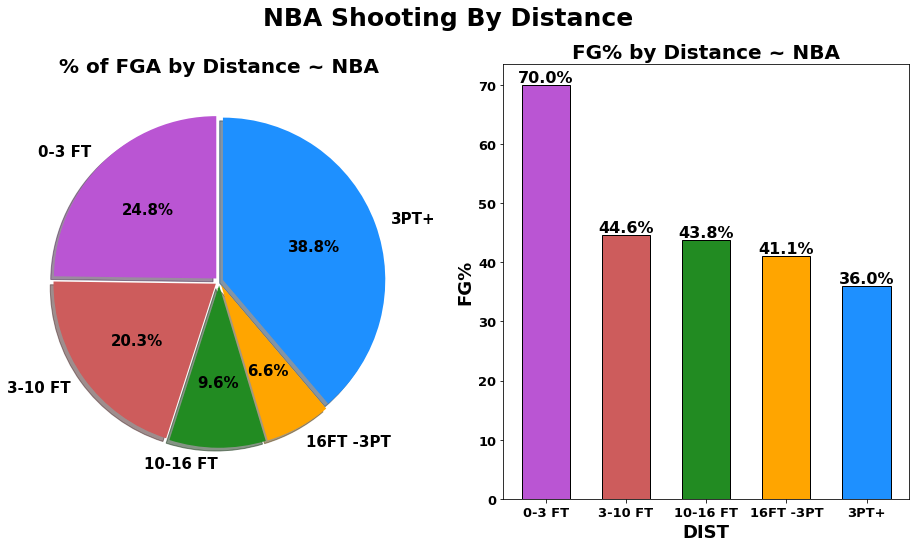

In [ ]:
def nba_fg_by_dist():
    # Set the default figure size
    plt.rcParams["figure.figsize"] = (10, 10)

    # Define colors for the pie chart
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']

    # Calculate the average values for % of FGA by distance
    att_dist_data = df_team_advshot[['% of FGA by Distance 0-3',
                                     '% of FGA by Distance 3-10',
                                     '% of FGA by Distance 10-16',
                                     '% of FGA by Distance 16-3P',
                                     '% of FGA by Distance 3P']].mean()

    # Define labels for the pie chart
    labels = ['0-3 FT', '3-10 FT', '10-16 FT', '16FT -3PT', '3PT+']

    # Define explode values for the pie chart
    explode = [0.025, 0.025, 0.025, 0.025, 0.025]

    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # Plot the pie chart for % of FGA by distance
    ax[0].pie(att_dist_data,
              labels=labels,
              explode=explode,
              shadow=True,
              colors=colors,
              autopct='%1.1f%%',
              startangle=90,
              textprops={'fontsize': 15, 'fontweight': 'bold'})
    ax[0].set_title('% of FGA by Distance ~ NBA', fontsize=20, fontweight='bold')

    # Calculate the average values for FG% by distance
    per_dist_data = df_team_advshot[['FG% by Distance 0-3',
                                     'FG% by Distance 3-10',
                                     'FG% by Distance 10-16',
                                     'FG% by Distance 16-3P',
                                     'FG% by Distance 3P']].mean() * 100

    # Extract keys and values for bar chart
    per_dist = list(per_dist_data.keys())
    per_values = list(per_dist_data)

    # Set the width of the bars
    barWidth = 0.6

    # Plot the bar chart for FG% by distance
    ax[1].bar(per_dist, per_values, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt='%.1f%%')
    ax[1].set_title('FG% by Distance ~ NBA', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')

    # Set the main title for the entire plot
    plt.suptitle('NBA Shooting By Distance', fontsize=25, fontweight='bold')

    # Display the plot
    plt.show()

# Call the function to generate and display the plot
nba_fg_by_dist()


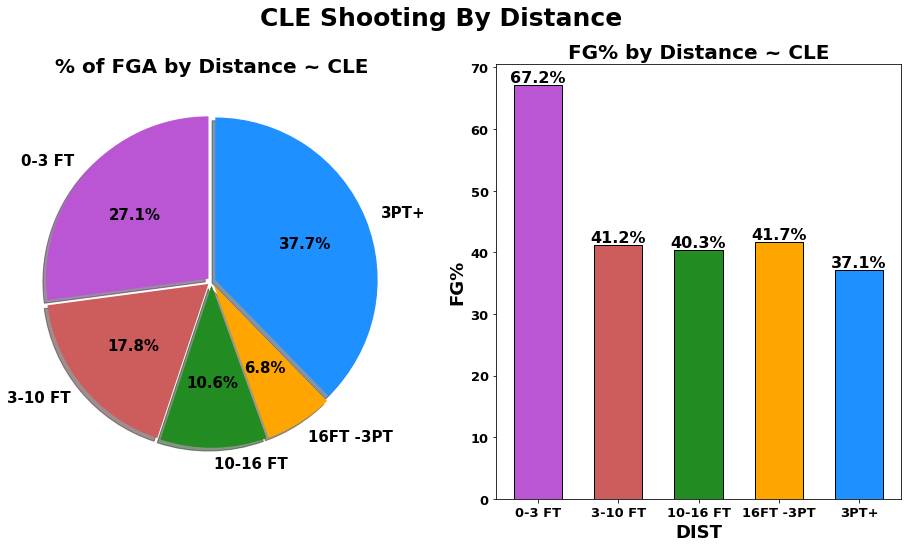

In [ ]:
def team_fg_by_dist(abbr):
    # Define colors for the pie chart and set the bar width
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']
    barWidth = 0.6

    # Set the default figure size
    plt.rcParams["figure.figsize"] = (10, 10)

    # Extract % of FGA by distance data for the specified team abbreviation
    dist_data = list(np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['% of FGA by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['% of FGA by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['% of FGA by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['% of FGA by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['% of FGA by Distance 3P'].item()]))

    # Extract FG% by distance data for the specified team abbreviation and convert to percentage
    dist_data_pct = np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['FG% by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['FG% by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['FG% by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['FG% by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR'] == abbr]['FG% by Distance 3P'].item()]) * 100

    # Define labels for the pie chart
    labels = ['0-3 FT', '3-10 FT', '10-16 FT', '16FT -3PT', '3PT+']

    # Define explode values for the pie chart
    explode = [0.025, 0.025, 0.025, 0.025, 0.025]

    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # Plot the pie chart for % of FGA by distance
    ax[0].pie(dist_data,
              labels=labels,
              explode=explode,
              shadow=True,
              colors=colors,
              autopct='%1.1f%%',
              startangle=90,
              textprops={'fontsize': 15, 'fontweight': 'bold'})
    ax[0].set_title(f'% of FGA by Distance ~ {abbr}', fontsize=20, fontweight='bold')

    # Plot the bar chart for FG% by distance
    ax[1].bar(labels, dist_data_pct, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt='%.1f%%')
    ax[1].set_title(f'FG% by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')

    # Set the main title for the entire plot
    plt.suptitle(f'{abbr} Shooting By Distance', fontsize=25, fontweight='bold')

    # Display the plot
    plt.show()

# Call the function for the specified team abbreviation ('CLE')
team_fg_by_dist('CLE')


## Function to return a teams dataframe

In [ ]:
def get_team_df(TEAM_ABBR):
    # Filter the DataFrame 'df' to include only rows where 'TEAM_ABBREVIATION' matches the provided 'TEAM_ABBR'
    team_df = df[df['TEAM_ABBREVIATION'] == TEAM_ABBR]

    # Return the filtered DataFrame for the specified team abbreviation
    return team_df


## Webscrape NBA records data into a pandas dataframe

In [ ]:
# Define the desired columns for the new DataFrame
columns = ['TEAM_ABBR','TEAM_NAME','CONFERENCE','GAMES','WINS','LOSES','WIN_PER','LAST_10_WINS','LAST_10_LOSES','HOME_WINS','HOME_LOSES','AWAY_WINS','AWAY_LOSES',
           'WEST_WINS', 'WEST_LOSES', 'EAST_WINS', 'EAST_LOSES']

# Initialize an empty list to store dictionaries representing each team's record
data_records = []

# Define a dictionary mapping team abbreviations to their respective conferences
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

# Loop through unique team abbreviations in the DataFrame
for i in df.TEAM_ABBREVIATION.unique():
    # Extract relevant information for each team
    team_abbr = i
    team_name = team_abbr_name_dict[i]
    games = df[(df['TEAM_ABBREVIATION']==i)]['WL'].count()
    wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')]['WL'].count()
    loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')]['WL'].count()
    win_per = wins/games

    # Get the last 10 games for the team
    last_10_df = get_team_df(i).head(10)
    last_10_wins = last_10_df[last_10_df['WL']=='W']['WL'].count()
    last_10_loses = last_10_df[last_10_df['WL']=='L']['WL'].count()

    # Calculate various win/loss statistics for home and away games
    home_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    home_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    away_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    away_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='AWAY')]['WL'].count()

    # Calculate win/loss statistics based on the opponent's conference
    west_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    west_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    east_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    east_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()

    # Determine the conference of the team
    conference = conferences[i]

    # Create a dictionary for the team's record
    values = [team_abbr, team_name, conference, games, wins, loses, win_per, last_10_wins, last_10_loses, home_wins, home_loses, away_wins, away_loses,
              west_wins, west_loses, east_wins, east_loses]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)

    # Append the dictionary to the list
    data_records.append(a_dictionary)

# Create a DataFrame from the list of team records, sort it by the number of wins in descending order, and reset the index
df_records = pd.DataFrame(data_records).sort_values('WINS',ascending=False).reset_index(drop=True)

# Display the resulting DataFrame
df_records


,TEAM_ABBR,TEAM_NAME,CONFERENCE,GAMES,WINS,LOSES,WIN_PER,LAST_10_WINS,LAST_10_LOSES,HOME_WINS,HOME_LOSES,AWAY_WINS,AWAY_LOSES,WEST_WINS,WEST_LOSES,EAST_WINS,EAST_LOSES
0,BOS,Boston Celtics,EAST,51,36,15,0.70588,6,3,19,6,17,9,14,4,22,11
1,DEN,Denver Nuggets,WEST,51,35,16,0.68627,7,3,23,4,12,12,24,9,11,7
2,MIL,Milwaukee Bucks,EAST,51,34,17,0.66667,7,3,21,5,13,12,12,4,22,13
3,PHI,Philadelphia 76ers,EAST,49,32,17,0.65306,7,2,19,8,13,9,13,5,19,12
4,MEM,Memphis Grizzlies,WEST,50,32,18,0.64,4,5,21,3,11,15,13,14,19,4
5,CLE,Cleveland Cavaliers,EAST,53,31,22,0.58491,4,6,21,6,10,16,12,12,19,10
6,BKN,Brooklyn Nets,EAST,50,31,19,0.62,4,5,15,8,16,11,9,8,22,11
7,LAC,Los Angeles Clippers,WEST,54,29,25,0.53704,7,3,14,11,15,14,17,14,12,11
8,MIA,Miami Heat,EAST,52,29,23,0.55769,7,3,17,9,12,14,14,9,15,14
9,SAC,Sacramento Kings,WEST,49,28,21,0.57143,6,3,16,11,12,10,16,10,12,11


## Merge W-L onto Team Averages DF

In [ ]:
# Perform a left merge between df_records and df_team_avg
df_team_avg_wl = pd.merge(df_records[['TEAM_ABBR','TEAM_NAME','WINS','LOSES','WIN_PER']],
                          df_team_avg.drop(columns=['TEAM_NAME']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

# Display the first few rows of the merged DataFrame
df_team_avg_wl.head()


,TEAM_ABBR,TEAM_NAME,WINS,LOSES,WIN_PER,PTS,AST,BLK,DREB,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OPP_PTS,OREB,PF,PLUS_MINUS,REB,STL,TEAM_ID,TOV
0,BOS,Boston Celtics,36,15,0.70588,117.62,26.173,5.3846,34.981,46.423,26.25,52.5,41.615,15.5,0.37167,46.5,88.038,41.75,0.47602,0.52635,0.47365,0.62881,0.37119,0.44651,0.3944,0.15909,22.442,18.615,0.83244,242.21,111.52,9.6538,18.75,6.0962,44.635,6.3654,1.6106e+09,13.385
1,DEN,Denver Nuggets,35,16,0.68627,116.65,28.647,4.4314,32.686,55.176,31.431,62.863,30.882,12.255,0.39425,36.765,86.059,43.686,0.50918,0.64115,0.35885,0.71763,0.28237,0.53998,0.31463,0.14539,22.804,17.02,0.74825,240.98,112.73,10.098,19.294,3.9216,42.784,7.4706,1.6106e+09,15.02
2,MIL,Milwaukee Bucks,34,17,0.66667,114.25,24.765,5.1373,36.961,50.392,27.216,54.431,39.725,14.314,0.36143,42.941,90.118,41.529,0.462,0.55887,0.44113,0.65335,0.34665,0.47493,0.37665,0.14842,22.843,16.882,0.74324,241.96,111.92,11.882,18.353,2.3333,48.843,6.7843,1.6106e+09,15.333
3,PHI,Philadelphia 76ers,32,17,0.65306,114.44,25.3,4.82,32.02,51.22,27.94,55.88,33.42,12.86,0.38134,38.58,84.64,40.8,0.48304,0.60417,0.39583,0.68227,0.31773,0.48996,0.33544,0.1746,24.14,19.98,0.82654,241.3,110.66,8.66,20.72,3.78,40.68,8,1.6106e+09,14.12
4,MEM,Memphis Grizzlies,32,18,0.64,116.39,25.412,5.9412,35.078,59.686,32.176,64.353,32.98,11.314,0.34359,33.941,92.667,43.49,0.46992,0.64354,0.35646,0.74035,0.25965,0.55465,0.2895,0.15585,25.314,18.098,0.72622,239.8,112.04,13.275,20.02,4.3529,48.353,8.2745,1.6106e+09,14.314


## Master DataFrame for all team averages + records

In [ ]:
# Merge df_records with df_team_avg
df_team_master = pd.merge(df_records,
                          df_team_avg.drop(columns=['TEAM_NAME']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

# Merge df_team_master with df_team_advshot
df_team_master = pd.merge(df_team_master,
                          df_team_advshot.drop(columns=['TEAM_NAME']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

# Merge df_team_master with df_defense_allowed_team_avg
df_team_master = pd.merge(df_team_master,
                          df_defense_allowed_team_avg.drop(columns=['TEAM_NAME', 'OPP_PTS']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

# Display the first few rows of the resulting master DataFrame
df_team_master.head()


,TEAM_ABBR,TEAM_NAME,CONFERENCE,GAMES,WINS,LOSES,WIN_PER,LAST_10_WINS,LAST_10_LOSES,HOME_WINS,HOME_LOSES,AWAY_WINS,AWAY_LOSES,WEST_WINS,WEST_LOSES,EAST_WINS,EAST_LOSES,PTS,AST,BLK,DREB,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OPP_PTS,OREB,PF,PLUS_MINUS,REB,STL,TEAM_ID,TOV,G,MP,FG%,Dist,% of FGA by Distance 2P,% of FGA by Distance 0-3,% of FGA by Distance 3-10,% of FGA by Distance 10-16,% of FGA by Distance 16-3P,% of FGA by Distance 3P,FG% by Distance 2P,FG% by Distance 0-3,FG% by Distance 3-10,FG% by Distance 10-16,FG% by Distance 16-3P,FG% by Distance 3P,% of FG Ast'd 2P,% of FG Ast'd 3P,Dunks %FGA,Dunks Md.,Layups %FGA,Layups Md.,Corner %3PA,Corner 3P%,OPP_AST,OPP_BLK,OPP_DREB,OPP_FG2A,OPP_FG2M,OPP_FG2_PTS,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FG3_PTS,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FRAC_ATT_2PT,OPP_FRAC_ATT_3PT,OPP_FRAC_MK_2PT,OPP_FRAC_MK_3PT,OPP_FRAC_PTS_2PT,OPP_FRAC_PTS_3PT,OPP_FRAC_PTS_FT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_MIN,OPP_MONTH,OPP_OPP_PTS,OPP_OREB,OPP_PF,OPP_PLUS_MINUS,OPP_REB,OPP_STL,OPP_TOV
0,BOS,Boston Celtics,EAST,51,36,15,0.70588,6,3,19,6,17,9,14,4,22,11,117.62,26.173,5.3846,34.981,46.423,26.25,52.5,41.615,15.5,0.37167,46.5,88.038,41.75,0.47602,0.52635,0.47365,0.62881,0.37119,0.44651,0.3944,0.15909,22.442,18.615,0.83244,242.21,111.52,9.6538,18.75,6.0962,44.635,6.3654,1.6106e+09,13.385,51,12415,0.467,14.3,0.638,0.207,0.222,0.114,0.095,0.362,0.531,0.686,0.458,0.441,0.471,0.355,0.45,0.764,0.052,217,0.275,693,0.173,0.376,22.538,3.75,33.904,57.212,30.404,60.808,32.769,11.577,0.354,34.731,89.981,41.981,0.46748,0.63536,0.36464,0.72347,0.27653,0.54644,0.31042,0.14314,20.481,15.981,0.77871,242.21,8.0962,117.62,9.5962,19.442,-6.0962,43.5,6.4231,12.769
1,DEN,Denver Nuggets,WEST,51,35,16,0.68627,7,3,23,4,12,12,24,9,11,7,116.65,28.647,4.4314,32.686,55.176,31.431,62.863,30.882,12.255,0.39425,36.765,86.059,43.686,0.50918,0.64115,0.35885,0.71763,0.28237,0.53998,0.31463,0.14539,22.804,17.02,0.74825,240.98,112.73,10.098,19.294,3.9216,42.784,7.4706,1.6106e+09,15.02,51,12290,0.479,13.8,0.613,0.236,0.229,0.091,0.056,0.387,0.561,0.752,0.458,0.425,0.395,0.349,0.529,0.851,0.056,228,0.291,781,0.259,0.38,25.667,4.3529,30.451,52.98,29.706,59.412,33.451,11.686,0.34684,35.059,86.431,41.392,0.47992,0.61241,0.38759,0.71839,0.28161,0.53117,0.30719,0.16164,23.882,18.255,0.76504,240.98,8,116.65,9.8824,20.196,-3.9216,40.333,7.6667,13.902
2,MIL,Milwaukee Bucks,EAST,51,34,17,0.66667,7,3,21,5,13,12,12,4,22,13,114.25,24.765,5.1373,36.961,50.392,27.216,54.431,39.725,14.314,0.36143,42.941,90.118,41.529,0.462,0.55887,0.44113,0.65335,0.34665,0.47493,0.37665,0.14842,22.843,16.882,0.74324,241.96,111.92,11.882,18.353,2.3333,48.843,6.7843,1.6106e+09,15.333,51,12340,0.455,14.1,0.637,0.235,0.183,0.14,0.078,0.363,0.515,0.676,0.417,0.446,0.386,0.35,0.468,0.763,0.053,213,0.247,634,0.191,0.356,23.059,4.2941,33.451,58.588,30.176,60.353,33.431,11.686,0.34706,35.059,92.02,41.863,0.45655,0.6362,0.3638,0.71968,0.28032,0.54031,0.3118,0.14789,21.216,16.51,0.78082,241.96,8.0392,114.25,10.882,18.941,-2.3333,44.333,7.3137,12.431
3,PHI,Philadelphia 76ers,EAST,49,32,17,0.65306,7,2,19,8,13,9,13,5,19,12,114.44,25.3,4.82,32.02,51.22,27.94,55.88,33.42,12.86,0.38134,38.58,84.64,40.8,0.48304,0.60417,0.39583,0.68227,0.31773,0.48996,0.33544,0.1746,24.14,19.98,0.82654,241.3,110.66,8.66,20.72,3.78,40.68,8,1.6106e+09,14.12,49,11885,0.472,14.1,0.619,0.267,0.174,0.094,0.084,0.381,0.55,0.736,0.397,0.407,0.432,0.347,0.501,0.843,0.052,206,0.274,683,0.211,0.364,23.88,5.04,32.48,52.84,29.04,58.08,32.76,11.22,0.34364,33.66,85.6,40.26,0.4725,0.61726,0.38274,0.72116,0.27884,0.52619,0.30307,0.17074,24.16,18.92,0.77744,241.3,8.12,114.44,9.74,19.64,-3.78,42.22,6.84,15.24
4,MEM,Memphis Grizzlies,WEST,50,32,18,0.64,4,5,21,3,11,15,13,14,19,4,116.39,25.412,5.9412,35.078,59.686,32.176,64.353,32.98,11.314,0.34359,33.941,92.667,43.49,0.46992,0.64354,0.35646,0.74035,0.25965,0.55465,0.28

## Correlation Heatmap for Team Average DF

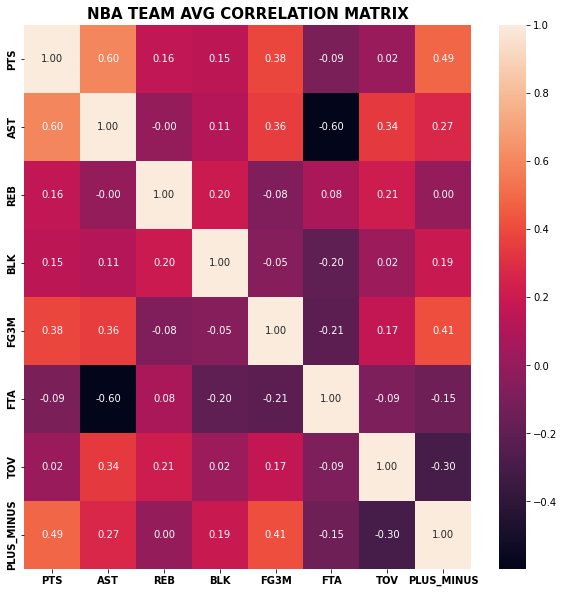

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns for correlation analysis
selected_columns = ['PTS', 'AST', 'REB', 'BLK', 'FG3M', 'FTA', 'TOV', 'PLUS_MINUS']

# Create a heatmap of the correlation matrix
sns.heatmap(df_team_avg[selected_columns].corr(), annot=True, fmt='.2f')

# Set plot title and adjust font properties
plt.title('NBA TEAM AVG CORRELATION MATRIX', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

# Show the heatmap
plt.show()


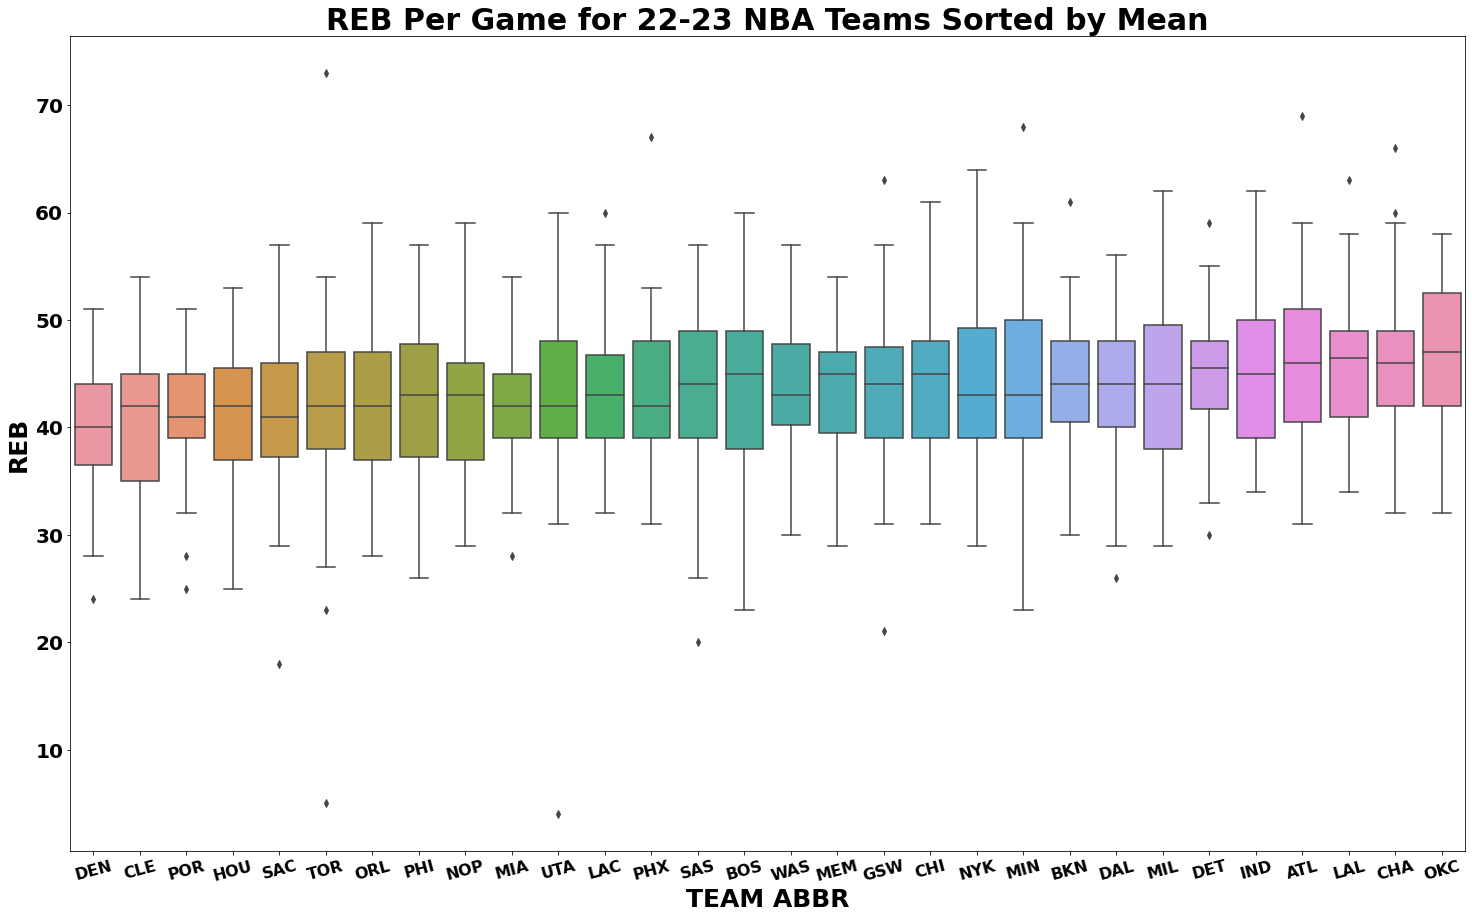

In [ ]:
def NBA_stat_boxplots(stat, sort_by='mean', asc=True):
    """
    Generate a box plot for the distribution of a given statistical variable across NBA teams.

    Parameters:
    - stat: The statistical variable (column) to be visualized.
    - sort_by: Sorting criterion ('mean' or 'median').
    - asc: Sorting order (True for ascending, False for descending).

    Returns:
    - Displays the box plot.
    """

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 15))

    # Sort teams based on mean or median
    if sort_by == 'mean':
        if asc:
            means_stat = df.groupby(['OPP_TEAM_ABBR'])[stat].mean().sort_values(ascending=True)
        else:
            means_stat = df.groupby(['OPP_TEAM_ABBR'])[stat].mean().sort_values(ascending=False)
        sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y=stat, order=means_stat.index)
        ax.set_title(f'{stat} Per Game for 22-23 NBA Teams Sorted by Mean', fontsize=30, fontweight='bold')

    elif sort_by == 'median':
        if asc:
            medians_stat = df.groupby(['OPP_TEAM_ABBR'])[stat].median().sort_values(ascending=True)
        else:
            medians_stat = df.groupby(['OPP_TEAM_ABBR'])[stat].median().sort_values(ascending=False)
        sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y=stat, order=medians_stat.index)
        ax.set_title(f'{stat} Per Game for 22-23 NBA Teams Sorted by Medians', fontsize=20)

    plt.xticks(rotation=15, fontsize=16, fontweight='bold')
    plt.yticks(rotation=0, fontsize=20, fontweight='bold')

    plt.xlabel('TEAM ABBR', fontsize=25, fontweight='bold')
    plt.ylabel(stat, fontsize=25, fontweight='bold')

    plt.show()

# Example usage for 'REB' (Rebounds)
NBA_stat_boxplots('REB')


## Plus-Minus Plot Function

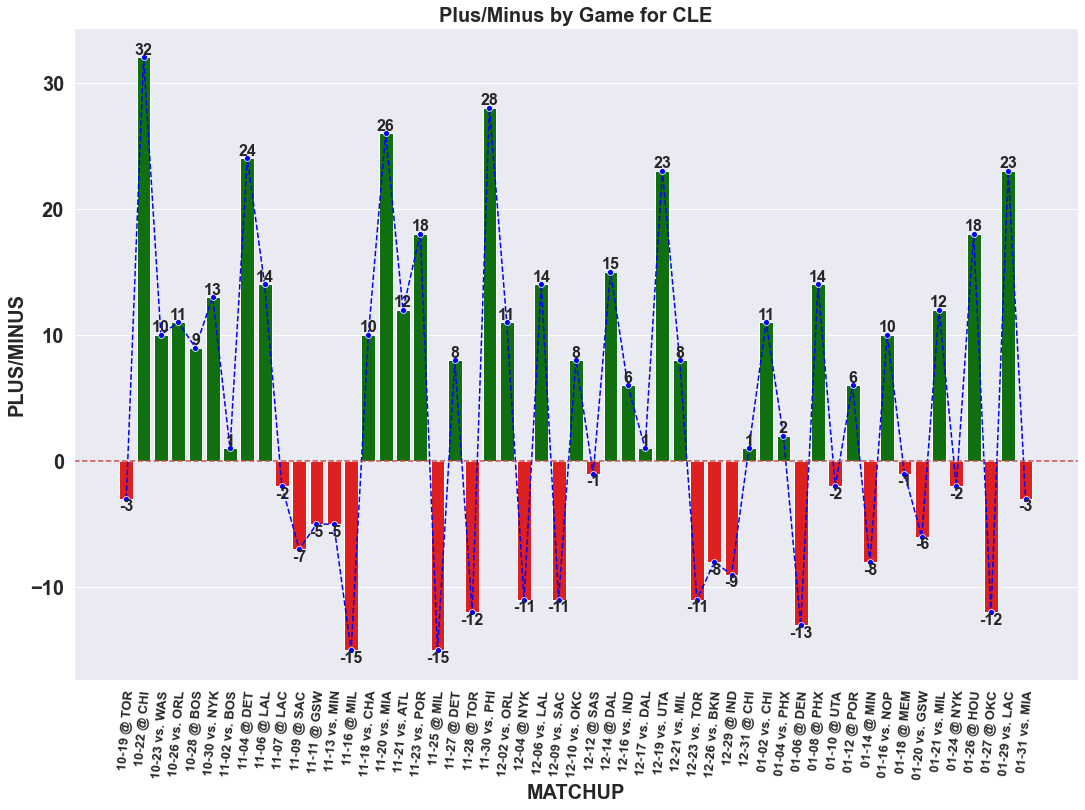

In [ ]:
def plus_minus_plot(team_abbr):
    """
    Generate a bar plot and a line plot to visualize the Plus/Minus by game for a specified NBA team.

    Parameters:
    - team_abbr: Abbreviation of the NBA team.

    Returns:
    - Displays the bar plot and line plot.
    """
    sns.set(rc={'figure.figsize': (18, 12)})

    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)

    values = np.array(df.PLUS_MINUS)
    pal = ['green' if (i > 0) else 'red' for i in values]

    ax1 = sns.barplot(data=df, x=df.index, y=values, palette=pal)

    ax1.bar_label(ax1.containers[0], fontsize=16, fontweight='bold')
    plt.title(f"Plus/Minus by Game for {team_abbr}", fontsize=20, fontweight='bold')

    ax2 = sns.lineplot(data=df, x=df.index, y="PLUS_MINUS", linestyle='--', color='blue', marker='o')
    plt.xticks(rotation=85)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.xticks(df.index, df["DATE_MATCHUP"].values, fontsize=13, fontweight='bold')
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')
    plt.ylabel('PLUS/MINUS', fontsize=20, fontweight='bold')

    plt.show()

# Example usage for 'CLE' (Cleveland Cavaliers)
plus_minus_plot('CLE')


## Scored vs Allowed Violin Plot Function

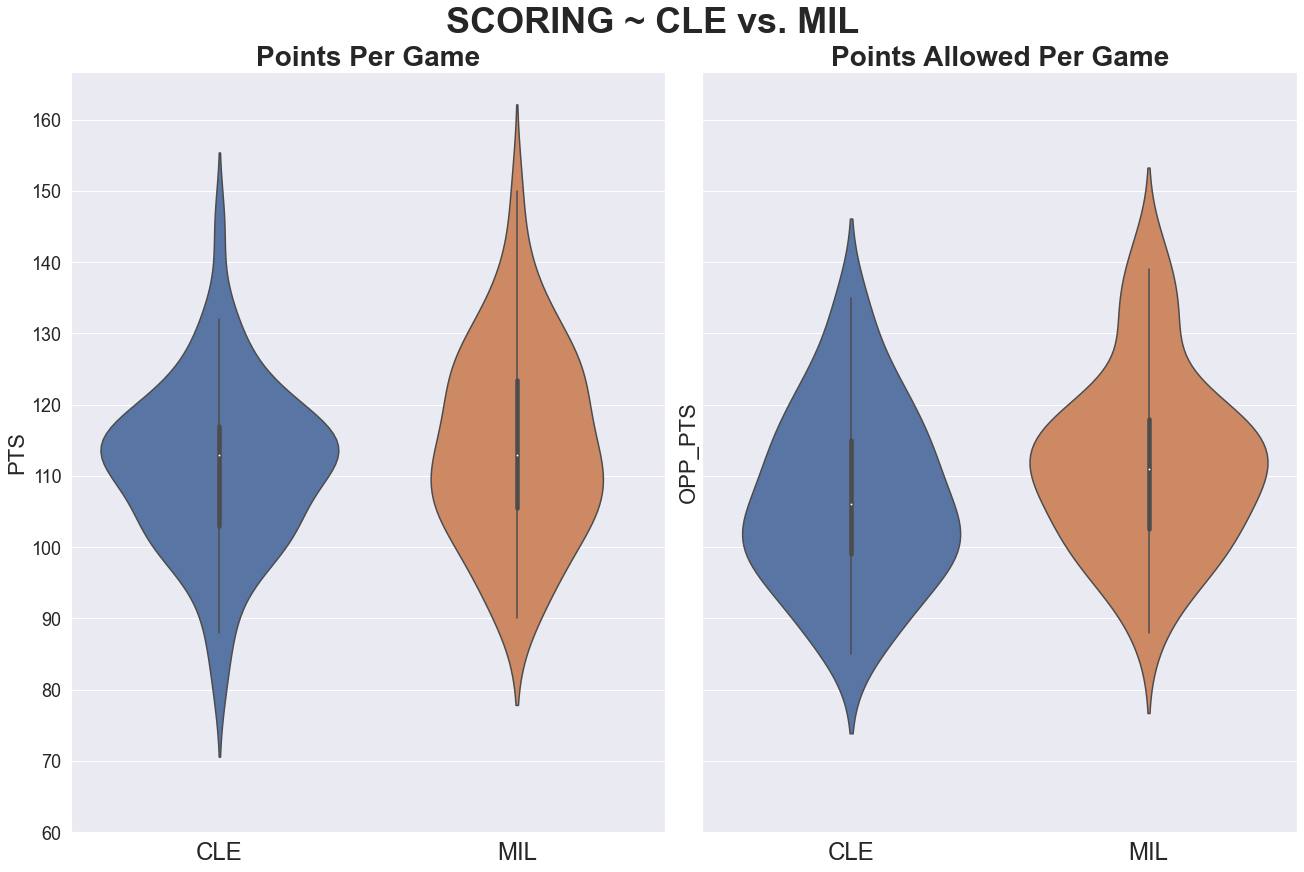

In [ ]:
def scored_allowed_compare(team_a_abbr, team_b_abbr):
    """
    Compare points scored (PTS) and points allowed (OPP_PTS) per game for two specified NBA teams using violin plots.

    Parameters:
    - team_a_abbr: Abbreviation of the first NBA team.
    - team_b_abbr: Abbreviation of the second NBA team.

    Returns:
    - Displays the violin plots comparing scoring and points allowed.
    """
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a, df_b])

    fig, axs = plt.subplots(ncols=2, sharey=True, constrained_layout=True)
    sns.set(rc={'figure.figsize': (18, 12)})

    ax2 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OPP_PTS', ax=axs[1])
    ax2.set_title('Points Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.tick_params(axis='x', which='major', labelsize=24)
    ax2.set_xlabel('')
    ax2.set_ylabel('OPP_PTS', fontsize=22)

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='PTS', ax=axs[0])
    ax1.set_title('Points Per Game', fontsize=28, fontweight='bold')
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)
    ax1.set_ylabel('PTS', fontsize=22)
    ax1.set_xlabel('')

    plt.yticks([60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160])
    fig.suptitle(f'SCORING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=36, fontweight='bold')
    plt.show()

# Example usage for comparing scoring between Cleveland Cavaliers (CLE) and Milwaukee Bucks (MIL)
scored_allowed_compare("CLE", "MIL")


## Wins vs Losses Pie Charts Function

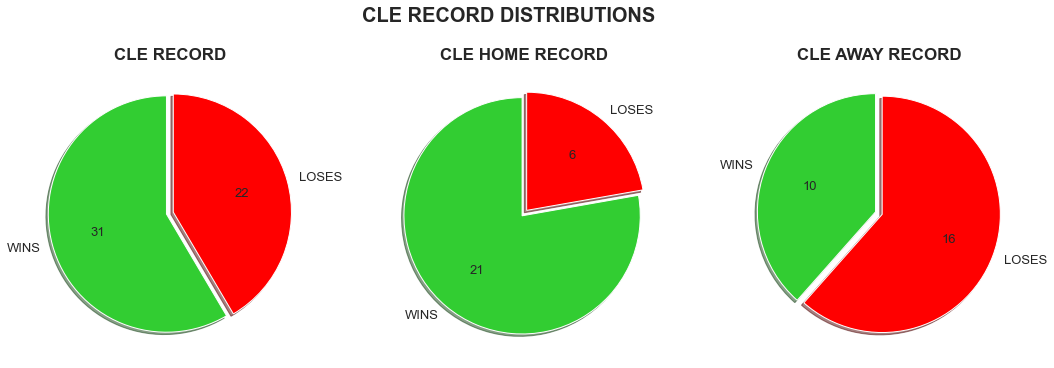

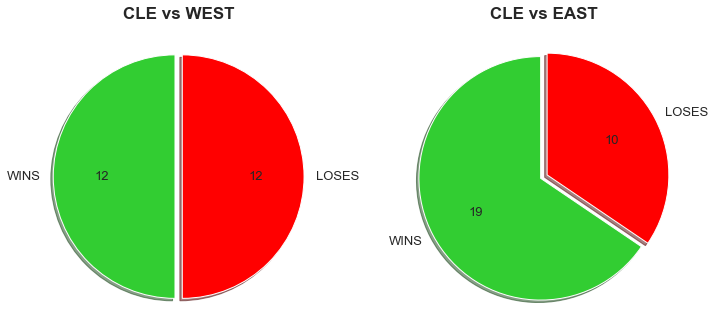

In [ ]:
def wl_pies(team_abbr):
    # Retrieve win-loss data for the specified team
    wl_data = np.array([df_records[df_records['TEAM_ABBR'] == team_abbr].WINS.item(), df_records[df_records['TEAM_ABBR'] == team_abbr].LOSES.item()])
    wl_data_home = np.array([df_records[df_records['TEAM_ABBR'] == team_abbr].HOME_WINS.item(), df_records[df_records['TEAM_ABBR'] == team_abbr].HOME_LOSES.item()])
    wl_data_away = np.array([df_records[df_records['TEAM_ABBR'] == team_abbr].AWAY_WINS.item(), df_records[df_records['TEAM_ABBR'] == team_abbr].AWAY_LOSES.item()])

    # Labels, colors, and explode values for pie charts
    labels = ['WINS', 'LOSES']
    colors = ['limegreen', 'red']
    explode = [0.03, 0.03]

    # Function to calculate absolute values for autopct
    def absolute_value_wl(val):
        a = np.round(val / 100. * wl_data.sum(), 0)
        return int(a)

    def absolute_value_wl_home(val):
        a = np.round(val / 100. * wl_data_home.sum(), 0)
        return int(a)

    def absolute_value_wl_away(val):
        a = np.round(val / 100. * wl_data_away.sum(), 0)
        return int(a)

    # Create subplots for overall, home, and away records
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    ax[0].pie(wl_data,
               labels=labels,
               explode=explode,
               startangle=90,
               colors=colors,
               shadow=True,
               autopct=absolute_value_wl,
               textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} RECORD", fontsize=17, fontweight='bold')

    ax[1].pie(wl_data_home,
               labels=labels,
               explode=explode,
               startangle=90,
               colors=colors,
               shadow=True,
               autopct=absolute_value_wl_home,
               textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} HOME RECORD", fontsize=17, fontweight='bold')

    ax[2].pie(wl_data_away,
               labels=labels,
               explode=explode,
               startangle=90,
               colors=colors,
               shadow=True,
               autopct=absolute_value_wl_away,
               textprops={'fontsize': 13})
    ax[2].set_title(f"{team_abbr} AWAY RECORD", fontsize=17, fontweight='bold')

    # Call additional function to display EAST and WEST records
    wl_pies_EW(team_abbr)

    # Display the plots
    plt.show()


def wl_pies_EW(team_abbr):
    # Retrieve win-loss data for the specified team against EAST and WEST
    wl_data_east = np.array([df_records[df_records['TEAM_ABBR'] == team_abbr].EAST_WINS.item(), df_records[df_records['TEAM_ABBR'] == team_abbr].EAST_LOSES.item()])
    wl_data_west = np.array([df_records[df_records['TEAM_ABBR'] == team_abbr].WEST_WINS.item(), df_records[df_records['TEAM_ABBR'] == team_abbr].WEST_LOSES.item()])

    # Labels, colors, and explode values for pie charts
    labels = ['WINS', 'LOSES']
    colors = ['limegreen', 'red']
    explode = [0.03, 0.03]

    # Functions to calculate absolute values for autopct
    def absolute_value_wl_east(val):
        a = np.round(val / 100. * wl_data_east.sum(), 0)
        return int(a)

    def absolute_value_wl_west(val):
        a = np.round(val / 100. * wl_data_west.sum(), 0)
        return int(a)

    # Create subplots for EAST and WEST records
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].pie(wl_data_west,
               labels=labels,
               explode=explode,
               startangle=90,
               colors=colors,
               shadow=True,
               autopct=absolute_value_wl_west,
               textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} vs WEST", fontsize=17, fontweight='bold')

    ax[1].pie(wl_data_east,
               labels=labels,
               explode=explode,
               startangle=90,
               colors=colors,
               shadow=True,
               autopct=absolute_value_wl_east,
               textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} vs EAST", fontsize=17, fontweight='bold')

    # Display the plots
    plt.show()


# Example usage for Cleveland Cavaliers (CLE)
wl_pies("CLE")


## Multi Team Violin Plot Comparsion Function

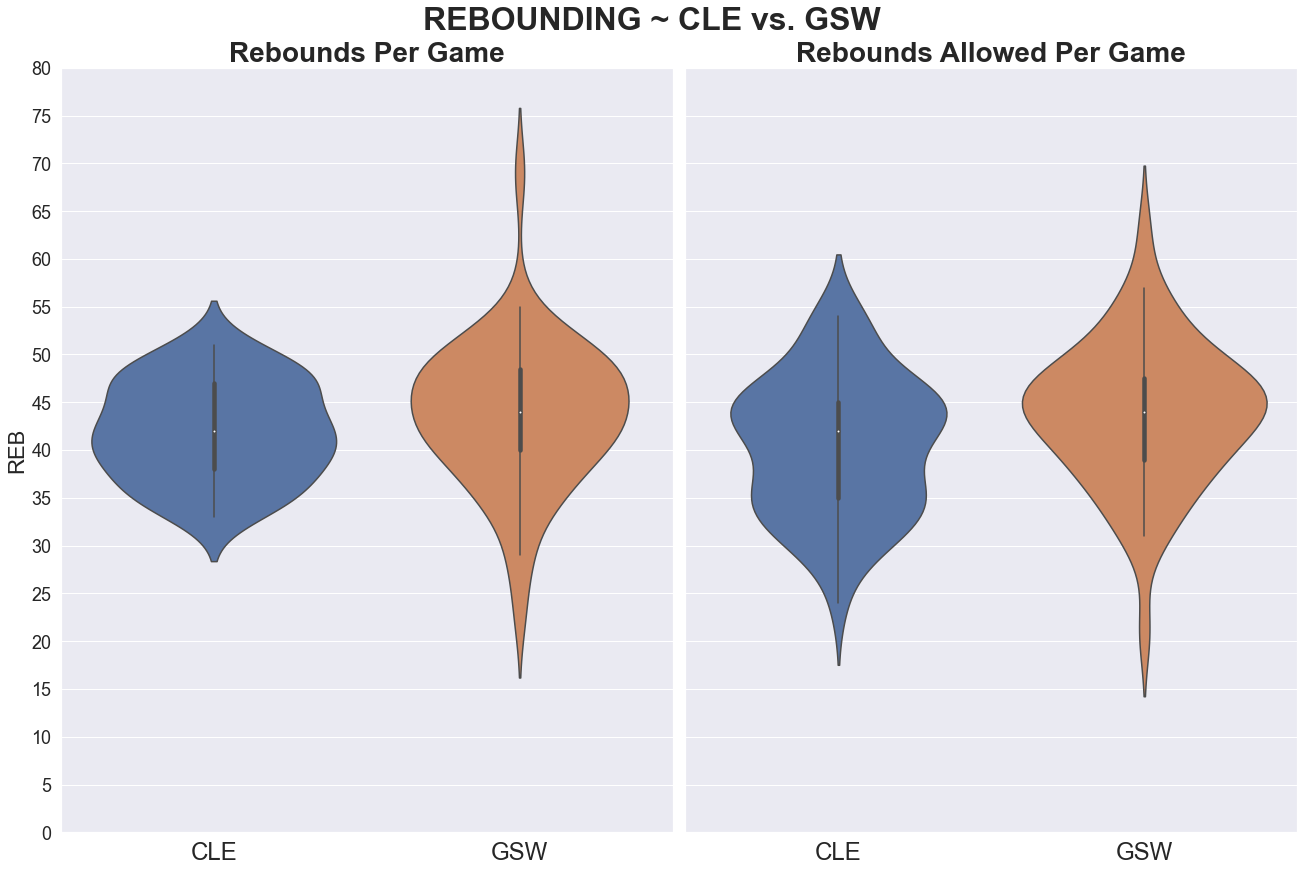

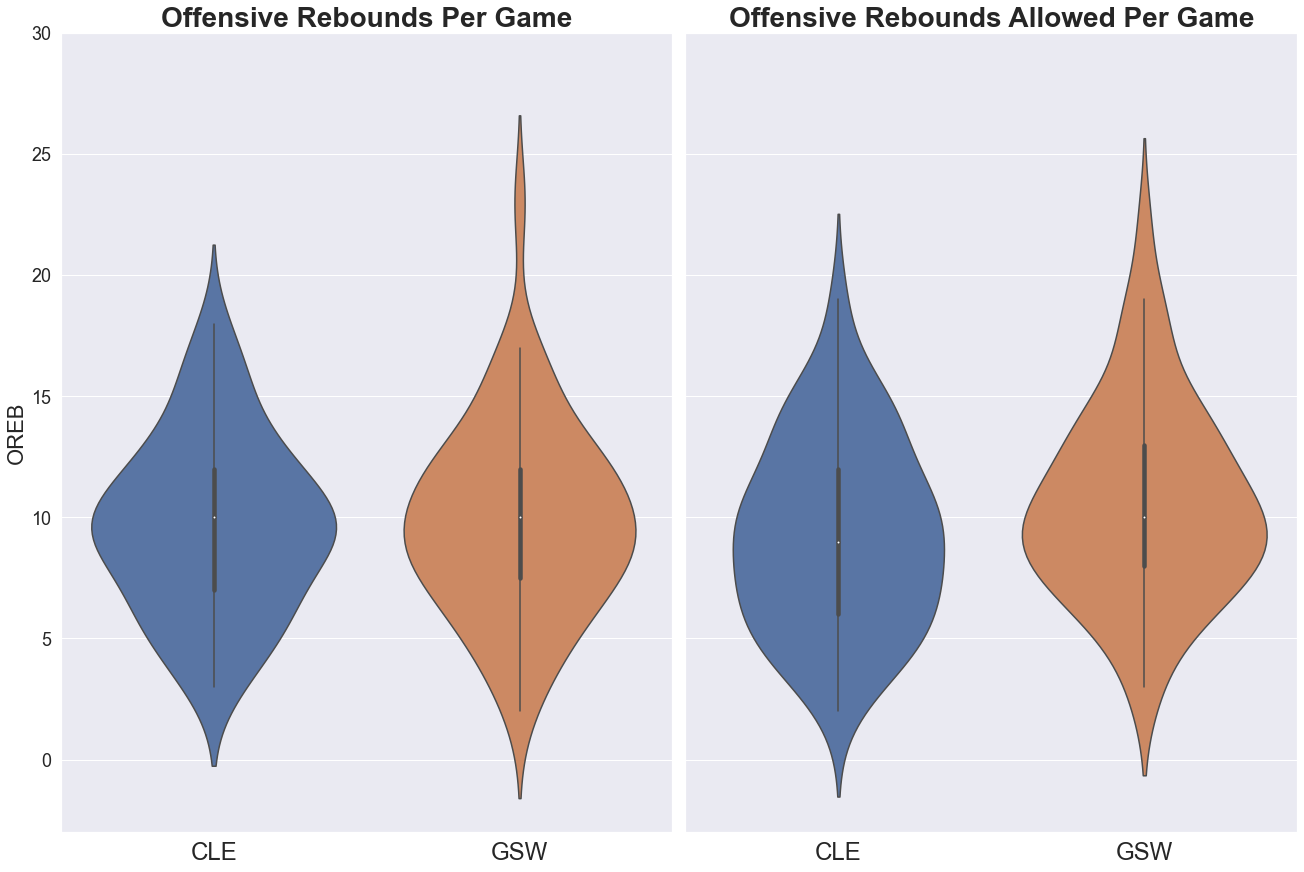

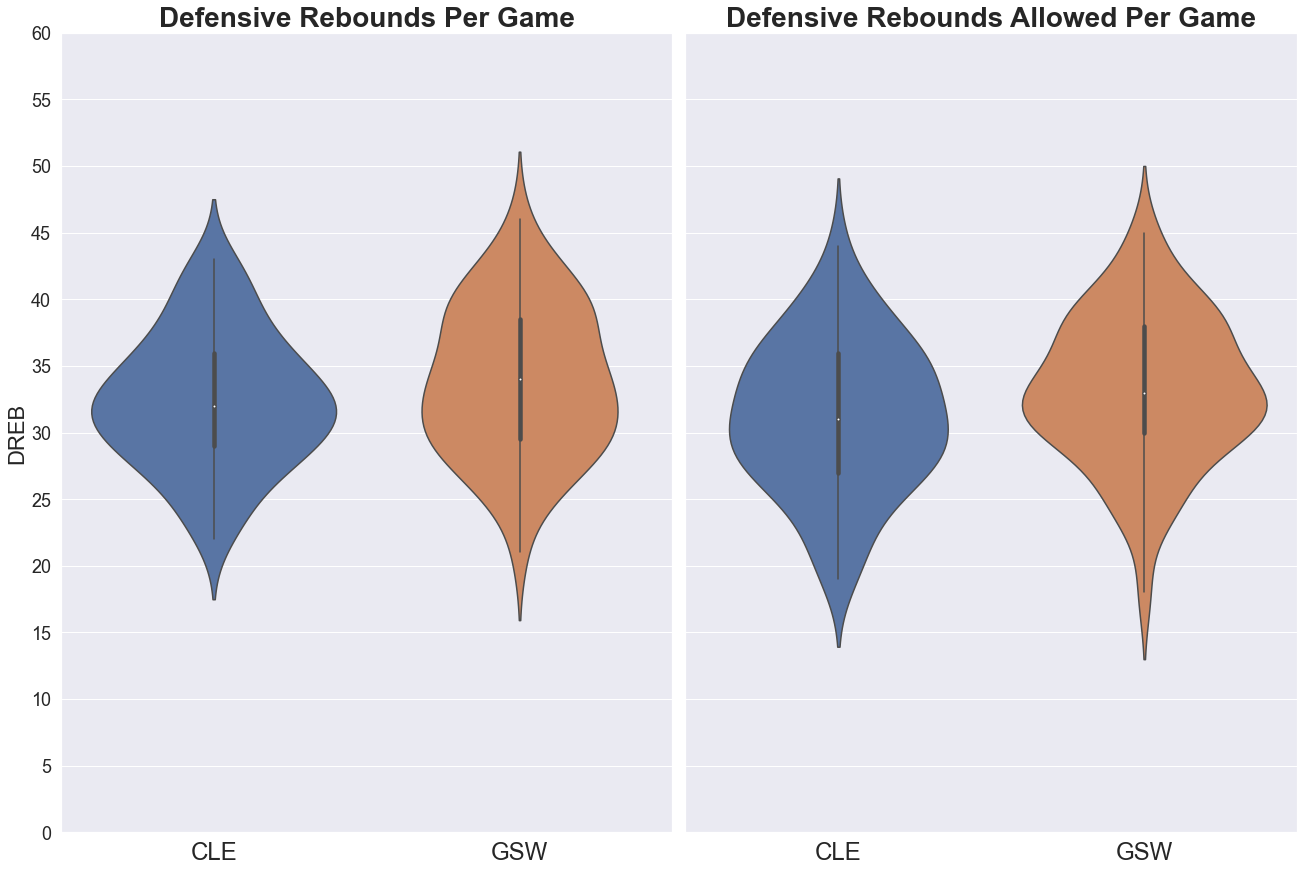

In [ ]:
def rebounds_compare(team_a_abbr, team_b_abbr):
    # Retrieve dataframes for the specified teams
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a, df_b])

    df_a_def = df[df.OPP_TEAM_ABBR == team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR == team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    # Create subplots for rebounds per game and rebounds allowed per game
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col', constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize': (18, 12)})

    # Violin plot for rebounds per game
    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='REB', ax=axs[0])
    ax1.set_title(f'Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('REB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    # Violin plot for rebounds allowed per game
    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='REB', ax=axs[1])
    ax2.set_title(f'Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])

    # Display the plots
    fig.suptitle(f'REBOUNDING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=32, fontweight='extra bold')
    plt.show()

    print()
    oreb_compare(team_a_abbr, team_b_abbr)
    print()
    dreb_compare(team_a_abbr, team_b_abbr)
    print()


    # ADD REBOUNDING DIFFERENTIALS

def oreb_compare(team_a_abbr, team_b_abbr):
    # Retrieve dataframes for the specified teams
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a, df_b])

    df_a_def = df[df.OPP_TEAM_ABBR == team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR == team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    # Create subplots for offensive rebounds per game and offensive rebounds allowed per game
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col', constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize': (18, 12)})

    # Violin plot for offensive rebounds per game
    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OREB', ax=axs[0])
    ax1.set_title(f'Offensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('OREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    # Violin plot for offensive rebounds allowed per game
    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='OREB', ax=axs[1])
    ax2.set_title(f'Offensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0, 5, 10, 15, 20, 25, 30])

    # Display the plots
    plt.show()


def dreb_compare(team_a_abbr, team_b_abbr):
    # Retrieve dataframes for the specified teams
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a, df_b])

    df_a_def = df[df.OPP_TEAM_ABBR == team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR == team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    # Create subplots for defensive rebounds per game and defensive rebounds allowed per game
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col', constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize': (18, 12)})

    # Violin plot for defensive rebounds per game
    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='DREB', ax=axs[0])
    ax1.set_title(f'Defensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('DREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    # Violin plot for defensive rebounds allowed per game
    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='DREB', ax=axs[1])
    ax2.set_title(f'Defensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

    # Display the plots
    plt.show()


rebounds_compare('CLE','GSW')

## Team Scoring Line Plot Function

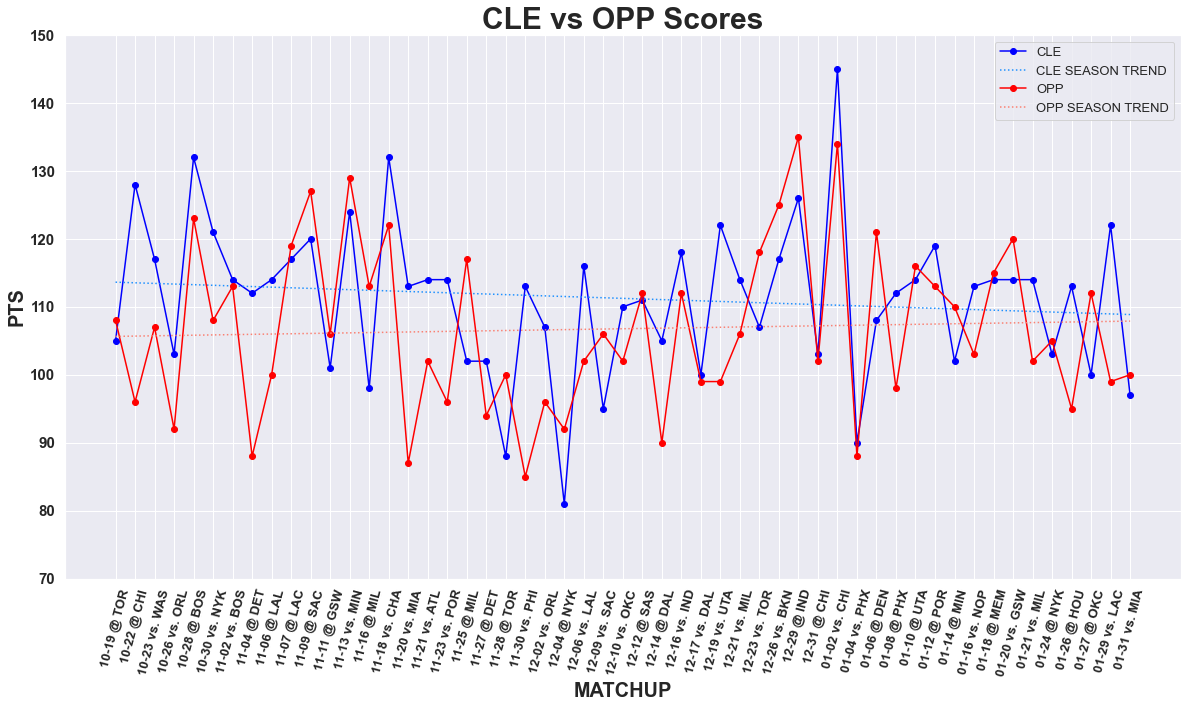

In [ ]:
def line_plot_scores(team_abbr):
    # Set the figure size
    plt.rcParams["figure.figsize"] = (20, 10)

    # Retrieve and sort the team's data by game date
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)

    # Plot the team's scores with a blue line and markers
    team_score = plt.plot(df.index, df['PTS'], marker='o', label=team_abbr, color='blue')

    # Fit a linear trend line to the team's scores
    z_team = np.polyfit(df.index, df['PTS'], 1)
    p_team = np.poly1d(z_team)

    # Plot the team's season trend with a dotted line
    team_trend = plt.plot(df.index, p_team(df.index), linestyle='dotted', linewidth=1.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')

    # Plot the opponent's scores with a red line and markers
    opp_score = plt.plot(df.index, df['OPP_PTS'], marker='o', label='OPP', color='red')

    # Fit a linear trend line to the opponent's scores
    z_opp = np.polyfit(df.index, df['OPP_PTS'], 1)
    p_opp = np.poly1d(z_opp)

    # Plot the opponent's season trend with a dotted line
    opp_trend = plt.plot(df.index, p_opp(df.index), linestyle='dotted', linewidth=1.5, color='salmon', label='OPP SEASON TREND')

    # Add legend, title, and labels
    plt.legend(loc='best', fontsize=13)
    plt.title(f'{team_abbr} vs OPP Scores', fontsize=30, fontweight='bold')
    plt.xticks(df.index, df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0, 160, 10)), fontsize=15, fontweight='bold')
    plt.ylim(70, 150)
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')

    # Display the plot
    plt.show()


## Trend Plot Scores Function

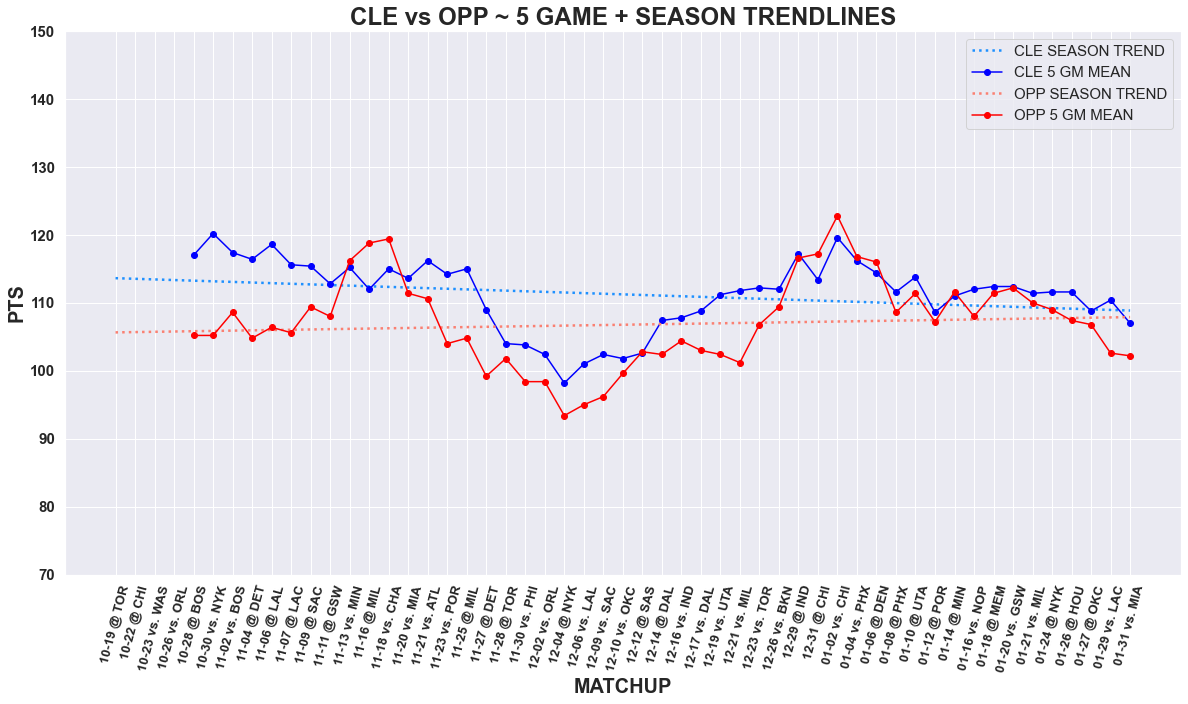

In [ ]:
def trend_plot_scores(team_abbr):
    # Set the figure size
    plt.rcParams["figure.figsize"] = (20, 10)

    # Retrieve and sort the team's data by game date
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)

    # Fit a linear trend line to the team's scores
    z_team = np.polyfit(df.index, df['PTS'], 1)
    p_team = np.poly1d(z_team)

    # Plot the team's season trend with a dotted line
    team_trend = plt.plot(df.index, p_team(df.index), linestyle='dotted', linewidth=2.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')

    # Calculate and plot the 5-game rolling average for the team's scores
    rolling_mean_team = df.PTS.rolling(5).mean()
    rolling_mean_plot_team = plt.plot(rolling_mean_team, color="blue", alpha=1, marker='o', label=f"{team_abbr} 5 GM MEAN")

    # Fit a linear trend line to the opponent's scores
    z_opp = np.polyfit(df.index, df['OPP_PTS'], 1)
    p_opp = np.poly1d(z_opp)

    # Plot the opponent's season trend with a dotted line
    opp_trend = plt.plot(df.index, p_opp(df.index), linestyle='dotted', linewidth=2.5, color='salmon', label='OPP SEASON TREND')

    # Calculate and plot the 5-game rolling average for the opponent's scores
    rolling_mean_opp = df.OPP_PTS.rolling(5).mean()
    rolling_mean_plot_opp = plt.plot(rolling_mean_opp, color="red", alpha=1, marker='o', label=f"OPP 5 GM MEAN")

    # Add legend, title, and labels
    plt.legend(loc='best', fontsize=15)
    plt.title(f'{team_abbr} vs OPP ~ 5 GAME + SEASON TRENDLINES', fontsize=24, fontweight='bold')
    plt.xticks(df.index, df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0, 160, 10)), fontsize=15, fontweight='bold')
    plt.ylim(70, 150)

    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()


## Shooting Distribution Pie Chart Function

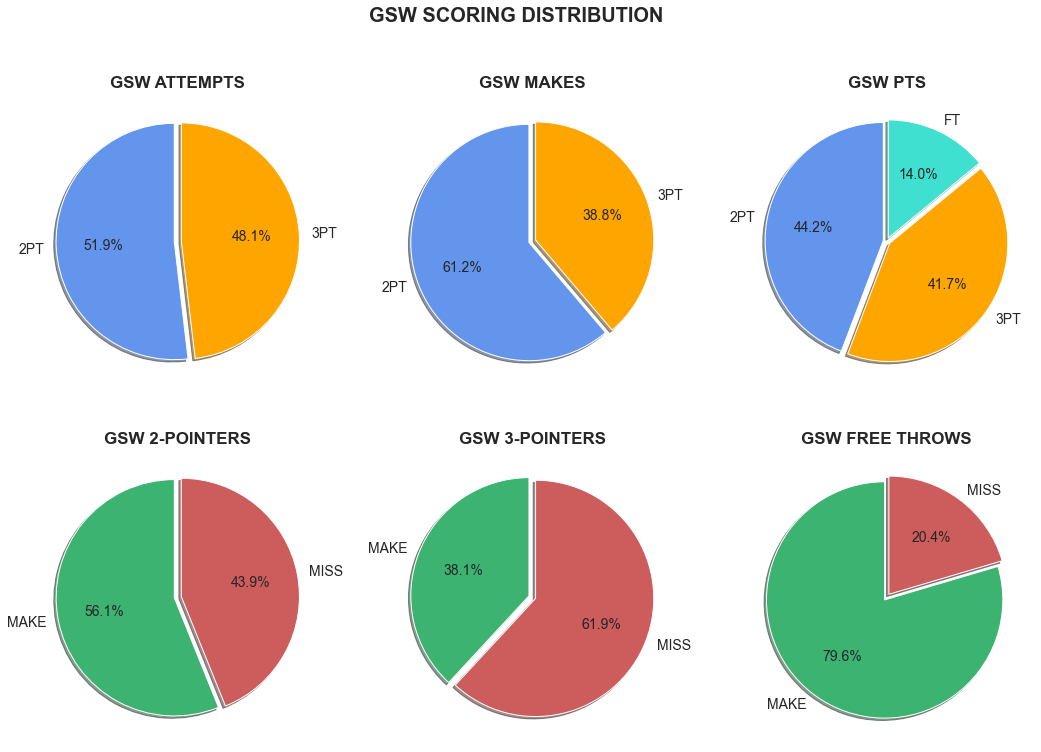

In [ ]:
def shot_pies(team_abbr):
    # Filter the DataFrame to get data for the specified team
    df_team = df_team_avg[df_team_avg['TEAM_ABBR'] == team_abbr]

    # Data for attempts, makes, and points for 2-pointers, 3-pointers, and free throws
    data_att = [df_team.FRAC_ATT_2PT.item(), df_team.FRAC_ATT_3PT.item()]
    data_mk = [df_team.FRAC_MK_2PT.item(), df_team.FRAC_MK_3PT.item()]
    data_pts = [df_team.FRAC_PTS_2PT.item(), df_team.FRAC_PTS_3PT.item(), df_team.FRAC_PTS_FT.item()]

    # Data for 2-pointers, 3-pointers, and free throws (makes and misses)
    data_2pt = [df_team.FG2M.item(), (df_team.FG2A.item() - df_team.FG2M.item())]
    data_3pt = [df_team.FG3M.item(), (df_team.FG3A.item() - df_team.FG3M.item())]
    data_ft = [df_team.FTM.item(), (df_team.FTA.item() - df_team.FTM.item())]

    # Labels for pie charts
    labels1 = ['2PT', '3PT']
    labels2 = ['2PT', '3PT', 'FT']
    labels3 = ['MAKE', 'MISS']

    # Explode settings for pie charts
    explode1 = [0.03, 0.03]
    explode2 = [0.03, 0.03, 0.03]

    # Colors for pie charts
    colors0 = ['cornflowerblue', 'orange']
    colors1 = ['cornflowerblue', 'orange', 'turquoise']
    colors2 = ['mediumseagreen', 'indianred']

    # Create subplots for the pie charts
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    # Plot pie charts for attempts, makes, and points
    ax[0, 0].pie(data_att, labels=labels1, explode=explode1, shadow=True, colors=colors0, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    ax[0, 0].set_title(f'{team_abbr} ATTEMPTS', fontsize=17, fontweight='bold')

    ax[0, 1].pie(data_mk, labels=labels1, explode=explode1, shadow=True, colors=colors0, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    ax[0, 1].set_title(f'{team_abbr} MAKES', fontsize=17, fontweight='bold')

    ax[0, 2].pie(data_pts, labels=labels2, explode=explode2, shadow=True, colors=colors1, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    ax[0, 2].set_title(f'{team_abbr} PTS', fontsize=17, fontweight='bold')

    # Plot pie charts for makes and misses of 2-pointers, 3-pointers, and free throws
    ax[1, 0].pie(data_2pt, labels=labels3, explode=explode1, colors=colors2, shadow=True, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    ax[1, 0].set_title(f'{team_abbr} 2-POINTERS', fontsize=17, fontweight='bold')

    ax[1, 1].pie(data_3pt, labels=labels3, explode=explode1, colors=colors2, shadow=True, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    ax[1, 1].set_title(f'{team_abbr} 3-POINTERS', fontsize=17, fontweight='bold')

    ax[1, 2].pie(data_ft, labels=labels3, explode=explode1, colors=colors2, shadow=True, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
    ax[1, 2].set_title(f'{team_abbr} FREE THROWS', fontsize=17, fontweight='bold')

    # Add a title to the entire figure
    fig.suptitle(f'{team_abbr} SCORING DISTRIBUTION', fontsize=20, fontweight="bold")

    # Display the pie charts
    plt.show()

shot_pies('GSW')

# Regrssion Analysis Plots ~ League Trends

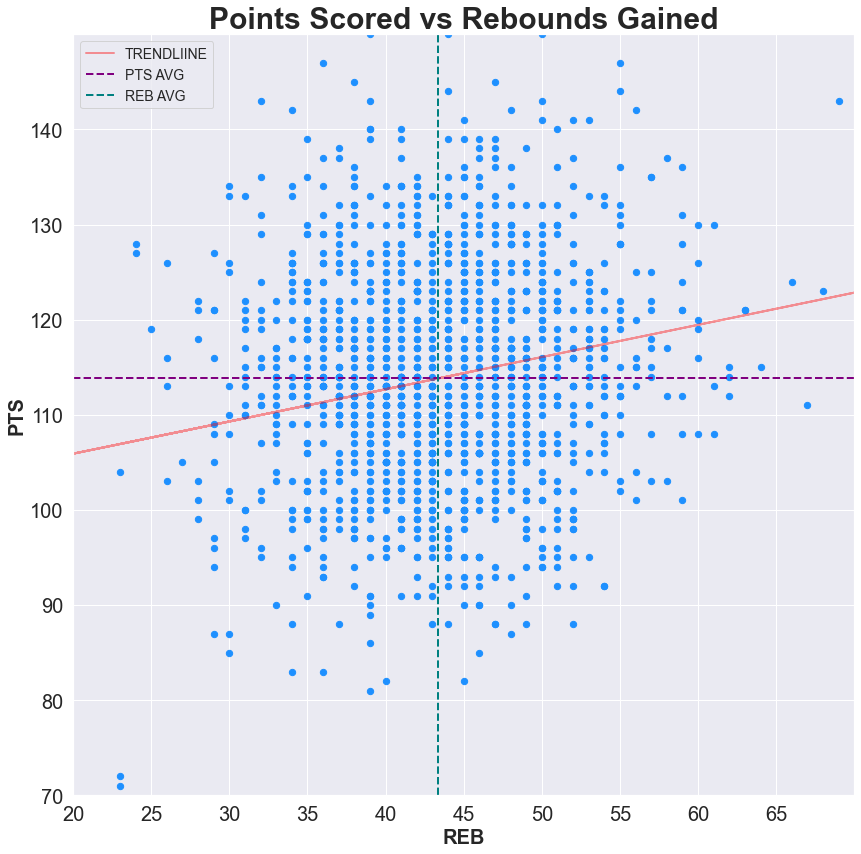

Season Trend Line Equation
y=0.338602x+(99.137197)

R-squared: 0.03498484322947659

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.7506
Date:                Wed, 01 Feb 2023   Prob (F-statistic):              0.393
Time:                        21:45:47   Log-Likelihood:                -71.689
No. Observations:                  31   AIC:                             147.4
Df Residuals:                      29   BIC:                             150.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [ ]:
plt.rcParams["figure.figsize"] = (14,14)

# Scatter plot
x = df.REB
y = df.PTS
plt.scatter(x, y, color='dodgerblue', s=40)

# Trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), label='TRENDLINE', linestyle='solid', alpha=0.4, color='red', linewidth=2)

# Average lines
plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.REB.mean(), label="REB AVG", linestyle='dashed', color='teal', linewidth=2)

# Set plot limits and labels
plt.xlim(20, 70)
plt.xticks(list(range(20, 70, 5)), fontsize=20)
plt.xlabel('REB', fontsize=20, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70, 150, 10)), fontsize=20)
plt.ylabel('PTS', fontsize=20, fontweight='bold')

# Legend and title
plt.legend(loc='best', fontsize=14)
plt.title('Points Scored vs Rebounds Gained', fontsize=30, fontweight='bold')

# Show the plot
plt.show()

# Display the trendline equation
print(color.BOLD + 'Season Trend Line Equation' + color.END)
print("y=%.6fx+(%.6f)" % (z[0], z[1]))

# Calculate R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: " + color.END + str(r_squared))

# Display the regression summary
lm = smf.ols(formula='PTS ~ REB', data=df_team_avg).fit()
print()
print(lm.summary())


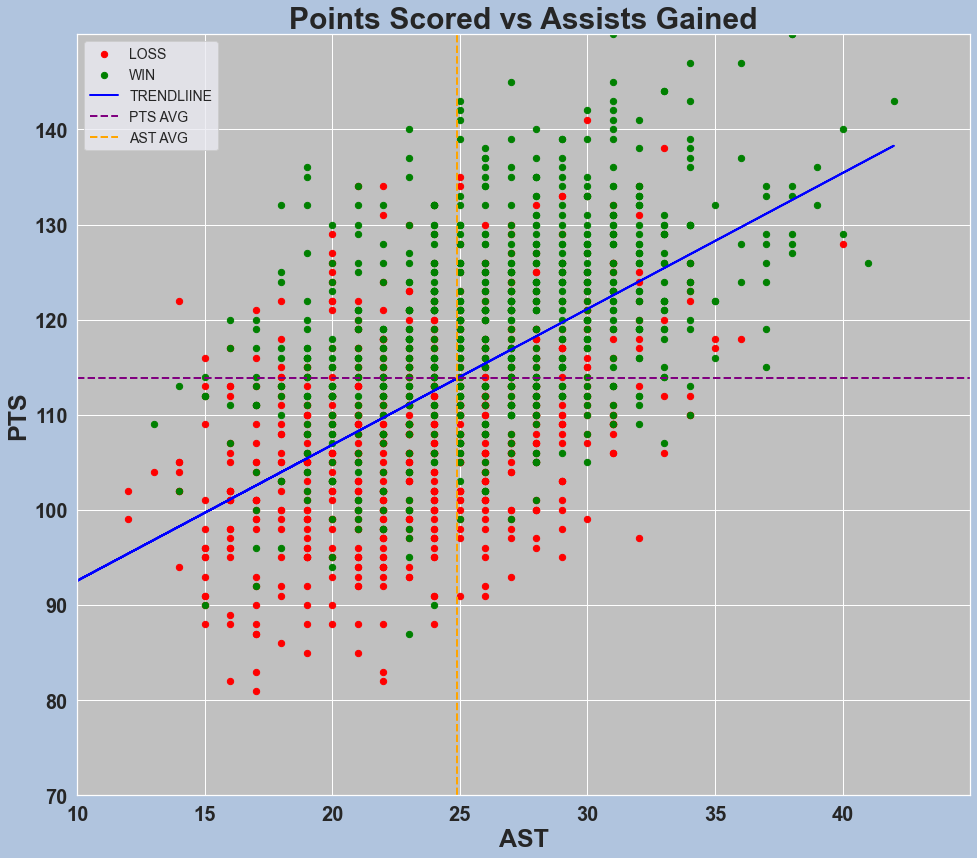

Season Trend Line Equation
y=1.428377x+(78.277840)

R-squared: 0.3188531648277789

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     16.21
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           0.000373
Time:                        21:45:47   Log-Likelihood:                -65.203
No. Observations:                  31   AIC:                             134.4
Df Residuals:                      29   BIC:                             137.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
ax.set_facecolor('silver')
fig.set_facecolor('lightsteelblue')
fig.set_edgecolor('black')

# Scatter plot
x = df.AST
y = df.PTS
x_L = df[df.WL == 'L'].AST
y_L = df[df.WL == 'L'].PTS
x_W = df[df.WL == 'W'].AST
y_W = df[df.WL == 'W'].PTS

plt.scatter(x_L, y_L, color='red', label='LOSS', s=40)
plt.scatter(x_W, y_W, color='green', label='WIN', s=40)

# Trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), label='TRENDLIINE', linestyle='solid', alpha=1, color='blue', linewidth=2)

# Average lines
plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.AST.mean(), label="AST AVG", linestyle='dashed', color='orange', linewidth=2)

# Set plot limits and labels
plt.xlim(10, 45)
plt.xticks(list(range(10, 45, 5)), fontsize=20, fontweight='bold')
plt.xlabel('AST', fontsize=25, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70, 150, 10)), fontsize=20, fontweight='bold')
plt.ylabel('PTS', fontsize=25, fontweight='bold')

# Legend and title
plt.legend(loc='best', fontsize=14)
plt.title('Points Scored vs Assists Gained', fontsize=30, fontweight='bold')

# Show the plot
plt.show()

# Display the trendline equation
print(color.BOLD + 'Season Trend Line Equation' + color.END)
print("y=%.6fx+(%.6f)" % (z[0], z[1]))

# Calculate R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: " + color.END + str(r_squared))

# Display the regression summary
lm = smf.ols(formula='PTS ~ AST', data=df_team_avg).fit()
print()
print(lm.summary())


## Team Average Reression (statx vs staty) Plot and Analysis Function

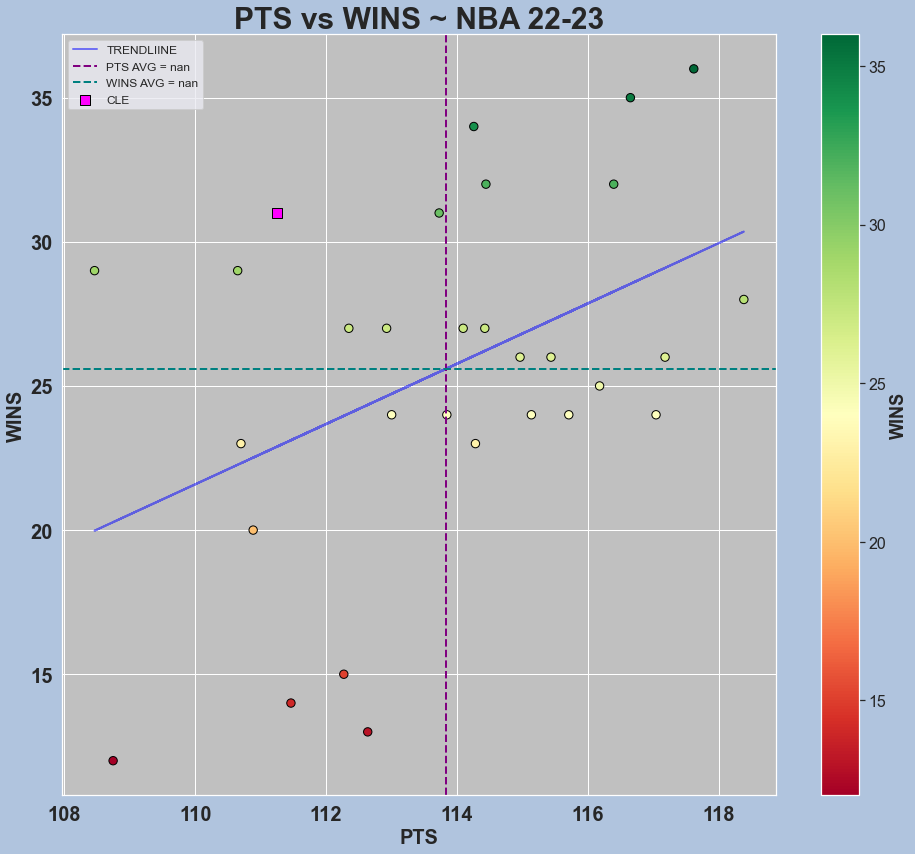


Season Trend Line Equation: y = 1.046140x + (-93.486904)

R-squared: 0.19015466144035043


                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     6.575
Date:                Wed, 01 Feb 2023   Prob (F-statistic):             0.0160
Time:                        21:45:48   Log-Likelihood:                -93.339
No. Observations:                  30   AIC:                             190.7
Df Residuals:                      28   BIC:                             193.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
def regression_analysis_team_avg(statx, staty, team_abbr=''):

    # Create a new plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))

    # Set plot background and edge color
    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')

    # Copy the master dataframe to a new one
    df_new = df_team_master.copy()

    # Extract data for x and y
    x = df_new[statx]
    y = df_new[staty]

    # Calculate the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), label='TRENDLINE', linestyle='solid', alpha=0.5, color='blue', linewidth=2)

    # Scatter plot with colormap based on y values
    plt.scatter(x, y, c=y, cmap='RdYlGn', edgecolor='black', s=70)

    # Average lines
    plt.axvline(x.mean(), label=f"{statx} AVG = {round(df_new[df_new['TEAM_ABBR']=='NBA'][statx].mean(), 2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"{staty} AVG = {round(df_new[df_new['TEAM_ABBR']=='NBA'][staty].mean(), 2)}", linestyle='dashed', color='teal', linewidth=2)

    # Labels and title
    plt.xlabel(statx, fontsize=20, fontweight='bold')
    plt.ylabel(staty, fontsize=20, fontweight='bold')
    plt.title(f'{statx} vs {staty} ~ NBA 22-23', fontsize=30, fontweight='bold')

    # Tick settings
    plt.xticks(fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')

    # Colorbar settings
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=staty, size=18, weight='bold')

    # Highlight data points for a specific team
    if team_abbr != '':
        try:
            x_team = df_new[df_new.TEAM_ABBR == team_abbr][statx]
            y_team = df_new[df_new.TEAM_ABBR == team_abbr][staty]
            plt.scatter(x_team, y_team, color='magenta', edgecolor='black', marker='s', s=100, label=team_abbr)
        except:
            pass

    # Display legend
    plt.legend(loc='best', fontsize=12)

    # Show the plot
    plt.show()

    # Display trendline equation
    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)" % (z[0], z[1]))

    # Calculate R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: " + color.END + str(r_squared))
    print()

    # Display regression summary
    lm = smf.ols(formula=f'{staty} ~ {statx}', data=df_new).fit()
    print()
    print(lm.summary())

# Example usage
regression_analysis_team_avg('PTS', 'WINS', team_abbr='CLE')


## Multi Linear Regression Model

In [ ]:
# Define a function for multiple linear regression
def multi_lin_reg(df, x, y):
    # Extract the independent variable(s) and dependent variable from the DataFrame
    x = df[x]
    y = df[y]

    # Add a constant term to the independent variable(s)
    x = sm.add_constant(x)

    # Fit the multiple linear regression model
    model = sm.OLS(y, x).fit()

    # Print the summary of the regression model
    print(model.summary())

# Example usage:
# Perform multiple linear regression with 'PTS' as the independent variable and 'WINS' as the dependent variable
multi_lin_reg(df_team_master, 'PTS', 'WINS')

# Example with multiple independent variables:
# Perform multiple linear regression with 'PTS', 'FG3M', 'REB', 'AST', and 'TOV' as independent variables,
# and 'WINS' as the dependent variable
multi_lin_reg(df_team_master, ['PTS', 'FG3M', 'REB', 'AST', 'TOV'], 'WINS')

                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     3.251
Date:                Wed, 01 Feb 2023   Prob (F-statistic):             0.0221
Time:                        21:45:48   Log-Likelihood:                -88.746
No. Observations:                  30   AIC:                             189.5
Df Residuals:                      24   BIC:                             197.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.6990     50.893     -0.584      0.5